- the idea was to compute a year where the equilibrium is reached, the problem is that the different models vary strongly in their interannual/decadal variability, even after doing a rolling average over 20 years.
- For some models, it is very "easy" to compute that year, for others, the thresholds would need to be set manually ...
    - e.g. in GloGEMFlow, when equilibrium is reached, the volume varies internally in a 50-year cycle (probably that has been set like that...). That means the internal variability gets only "removed" if doing a >50-yr rolling average !
    - other models have also interannual variability, but that is less regular and can be still visible on 20-year rolling averages and sometimes even on 100-yr rolling averages ...
- for the moment, I would prefer to use the 90% "response time", but there, I should properly check that it is really the last year where this threshold is reached ...
    - or maybe actually the first year is better in a case, where the volume then internally varies by more than +/- 10% afterwards ...

In [3]:
# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path
DATE = 'Jun29' #'apr04' (has OGGM runaway effect of glaciers inside)
fill_option = 'repeat_last_20yrs'
    

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

try:
    path_merged_runs_scaled = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)

except:
    path_merged_runs_scaled = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    # we don' want to have the extended dataset to get the equilibrium values ... 
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled)
    ds_reg_models_extend = xr.open_dataset(path_merged_runs_scaled_extend)

# --> comes from isimip3b_postprocessing_analysis/isimip3b_postprocess_to_monthly.ipynb
pd_global_temp_exp = pd.read_csv('../data/temp_ch_ipcc_isimip3b.csv', index_col = 0)

In [5]:
    pd_global_temp_exp_m_glac = get_glob_temp_exp(region='global_glacier')


NameError: name 'get_glob_temp_exp' is not defined

In [6]:
from help_func import pal_models, model_order, d_reg_num_name, model_order_anonymous
# remove OGGM_v153 and Huss
hue_order_anonymous = []
hue_order = model_order[:-2] 
glac_models = hue_order 
pal_models = pal_models[:-2]
pal_models = sns.color_palette(pal_models)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])

print(hue_order, hue_order_anonymous)
pal_models



['Rounce', 'Compagno', 'Zekollari', 'OGGM_v16', 'OGGM-VAS', 'GLIMB', 'Kraaijenbrink', 'James', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8', 'model 9']


[(0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744)]

In [7]:
# test without Zeokllari and OGGM-VAS
sel = False
if sel:
    glac_models = ['James', 'Rounce', 'Compagno', 'Kraaijenbrink', 'GLIMB', 'OGGM_v16'] #, 'OGGM-VAS', 'Zekollari'] # OGGM_v153, Huss
    ds_reg_models = ds_reg_models.sel(model_author=glac_models)
    ds_reg_models_vol = ds_reg_models.volume_m3.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

    # Let's take the median estimate from all glacier models for every RGI region and then do the sum:
else:    
    ds_reg_models = ds_reg_models.sel(model_author=glac_models)
    ds_reg_models_extend = ds_reg_models_extend.sel(model_author=glac_models)
    ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']
    ds_reg_models_extend_vol = ds_reg_models_extend.volume_m3
# Let's take the median estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
ds_reg_models_extend_vol = ds_reg_models_extend_vol.stack(experiments=['gcm','period_scenario'])

ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 


In [8]:
# true for all
init_vol = ds_reg_models_vol.isel(simulation_year=0)
ds_reg_models_vol_roll = 100*ds_reg_models_vol.rolling(simulation_year=20, center=True).mean()/init_vol
ds_reg_models_vol_extend_roll = 100*ds_reg_models_extend_vol.rolling(simulation_year=20, center=True).mean()/init_vol

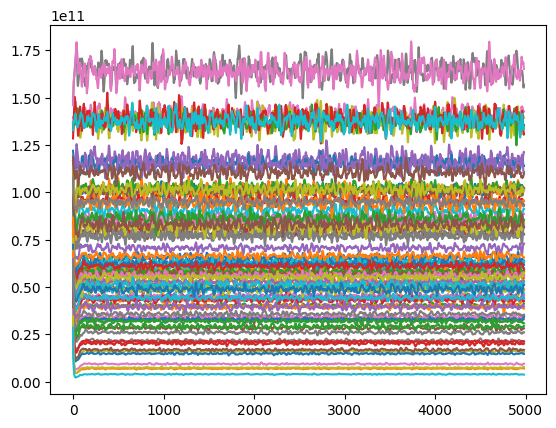

In [9]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='OGGM-VAS').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

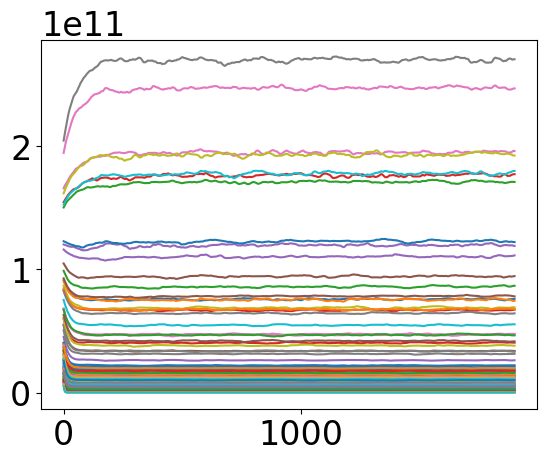

In [344]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='OGGM_v16').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

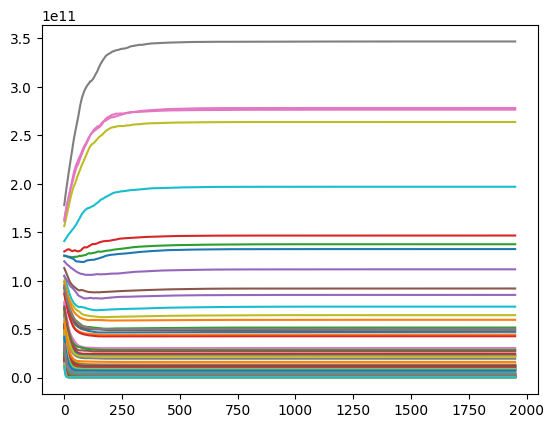

In [9]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=50,center=True).mean().sel(model_author='Rounce').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

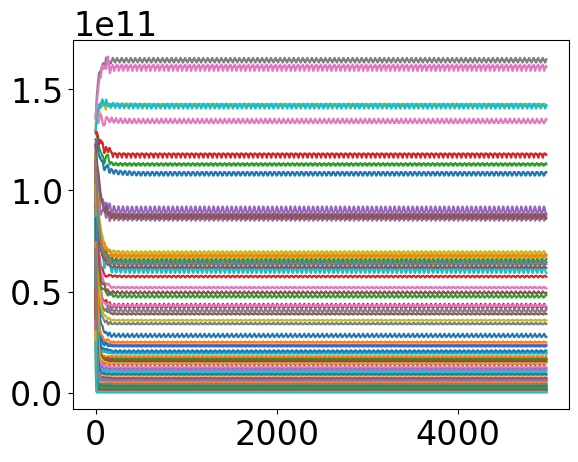

In [349]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='Compagno').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

(4000.0, 4400.0)

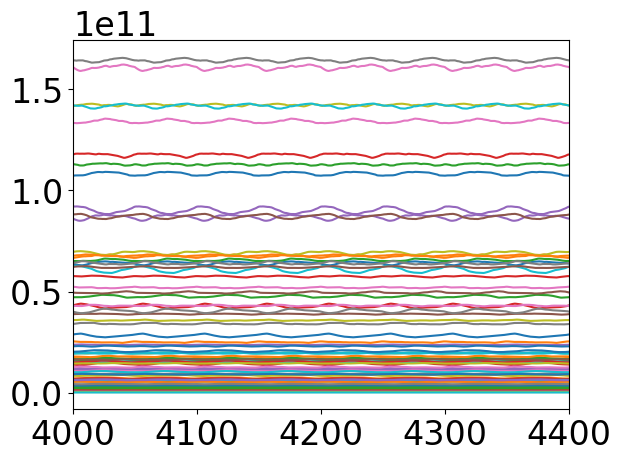

In [350]:
plt.plot(ds_sel);
plt.xlim([4000,4400])
# around 8 cycles in 400 years for GloGEMflow

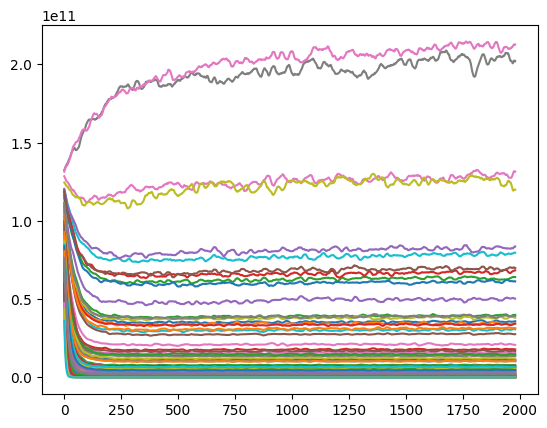

In [237]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='CISM2').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

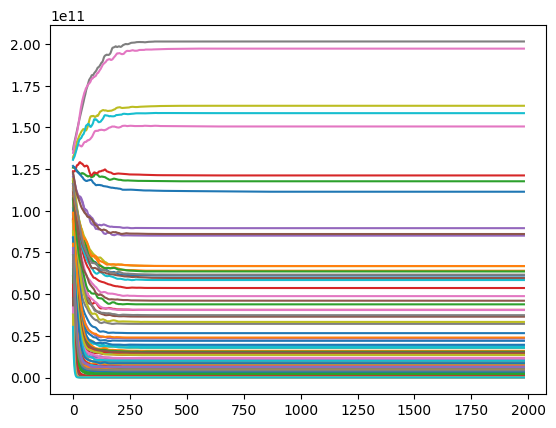

In [239]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='Zekollari').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

### We can still try to compute the equilibrium year, but it does not work for some models 

**try with differext avg_yrs**:
- the problem is then that there are regions/experiments where the equilibrium was actually reached earlier, but this is not visible depending on which avg_yrs rolling average is chose ... 

In [13]:
avg_yrs = 100# 100 #20
ds_reg_models_vol_roll_avg_yrs = 100*ds_reg_models_vol.rolling(simulation_year=avg_yrs, center=True).mean()/init_vol
ds_reg_models_vol_extend_roll_avg_yrs = 100*ds_reg_models_extend_vol.rolling(simulation_year=avg_yrs, center=True).mean()/init_vol
# let's do a loop, maybe there is an easier way, but it does not matter too much 
pd_l = []
for rgi_reg in ds_reg_models_vol.rgi_reg.values:
    for model in ds_reg_models_vol.model_author.values:
        
        ds_sel = ds_reg_models_vol_roll_avg_yrs.sel(model_author=model).sel(rgi_reg=rgi_reg).dropna(dim='simulation_year')
        #pd_ll = []
        for xperc in [1]:
            if len(ds_sel.simulation_year)==0:
                # just set NaN values everywhere
                equilibrium_yr_lower_xperc_ch = pd.DataFrame(index=ds_sel.experiments.to_dataframe().index, 
                     columns=['simulation_year'],
                     )['simulation_year']
                #print('NaN')
            else:
                end_yr = ds_sel.simulation_year[-1].values
                begin_yr = ds_sel.simulation_year[0].values
                total_change = np.abs(100 - ds_sel.sel(simulation_year=end_yr))
                # minimum is 33yrs in region 16, so maybe ok to use a 
                testi = ds_sel.sel(simulation_year=slice(avg_yrs+begin_yr,end_yr))
                # important to set here values, as we do not want to substract the same years!!!
                testi_b = ds_sel.sel(simulation_year=slice(begin_yr,end_yr-avg_yrs)).values
                # (V_roll(t) - V_roll(t-50) )/(2*((V_roll(t) + V_roll(t-50) ))
                # v_diff_20_yr = 100*np.abs((testi-testi_b))/(0.5*(testi+testi_b))
                # divide instead by total_change (otherwise we do have a problem if the volume gets very small... )
                # on the other hand, if total chane is small, we also get an issue 
                # v_diff_20_yr = 100*np.abs((testi-testi_b))/total_change
                # lets only do the difference 
                # ??? should we divide by the total change ???
                v_diff_avg_yrs = 100*np.abs((testi-testi_b))/total_change
                #v_diff_avg_yrs = np.abs((testi-testi_b))

                v_diff_avg_yrs = v_diff_avg_yrs.reset_coords()

                # for that we select the last average year where the difference is above xperc% 
                v_diff_avg_yrs_abovexperc = v_diff_avg_yrs.volume_m3.where(v_diff_avg_yrs.volume_m3>xperc).to_dataframe(f'volume_diff_after_{avg_yrs}_yrs').dropna()
                v_diff_avg_yrs_abovexperc = v_diff_avg_yrs_abovexperc.drop(columns=['period_scenario','gcm'])
                v_diff_avg_yrs_abovexperc = v_diff_avg_yrs_abovexperc.reset_index()
                #v_diff_20_yr_above1perc['experiments'] = v_diff_20_yr_above1perc['period_scenario'] + '_'+ v_diff_20_yr_1perc['gcm']

                v_diff_avg_yrs_last_yr_above_xperc = v_diff_avg_yrs_abovexperc.groupby(['gcm', 'period_scenario']).max()['simulation_year']

                # if it is the end of the timeseries (i.e. 1990 or 4990), it means that no equilibrium within the limits was reached , we set it to np.NaN
                #print(end_yr)
                # for the moment just set a larger number and then we need to check what to do!
                v_diff_avg_yrs_last_yr_above_xperc.loc[v_diff_avg_yrs_last_yr_above_xperc>=end_yr] = 100000
                # we need to add +1 (as we computed the last year where it was above 1)
                equilibrium_yr_lower_xperc_ch = v_diff_avg_yrs_last_yr_above_xperc + 1

                #print(v_diff_20_yr)
            # create pandas dataframe that can be concatenated ... 
            pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd.DataFrame(equilibrium_yr_lower_xperc_ch).rename(columns={'simulation_year':f'simulation_yr_where_equilibrium_lower_{xperc}perc_ch_reached'})

            # add temp. series ... 
            temp_values = pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()
            pd_equilibrium_yr_lower_xperc_ch_avg_yrs['temp_ch_ipcc']= temp_values.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.index]['temp_ch_ipcc'].values
            
            pd_equilibrium_yr_lower_xperc_ch_avg_yrs['rgi_reg'] = rgi_reg
            pd_equilibrium_yr_lower_xperc_ch_avg_yrs['model'] = model

            # for those experiments, we need to check the extended time series ... 
            #pd_equilibrium_yr_lower_1perc_ch.loc[pd_equilibrium_yr_lower_1perc_ch['simulation_yr_where_equilibrium_lower_1perc_ch_reached'].isna()]
        pd_l.append(pd_equilibrium_yr_lower_xperc_ch_avg_yrs)
pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd.concat(pd_l)

pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.reset_index()
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.index = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc
pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.dropna()
#pd_equilibrium_yr_lower_xperc_ch_avg_yrs_f = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>=0.8]
#pd_equilibrium_yr_lower_xperc_ch_avg_yrs_f.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs_f.simulation_yr_where_equilibrium_lower_1perc_ch_reached ==100001]#.groupby('rgi_reg').count()

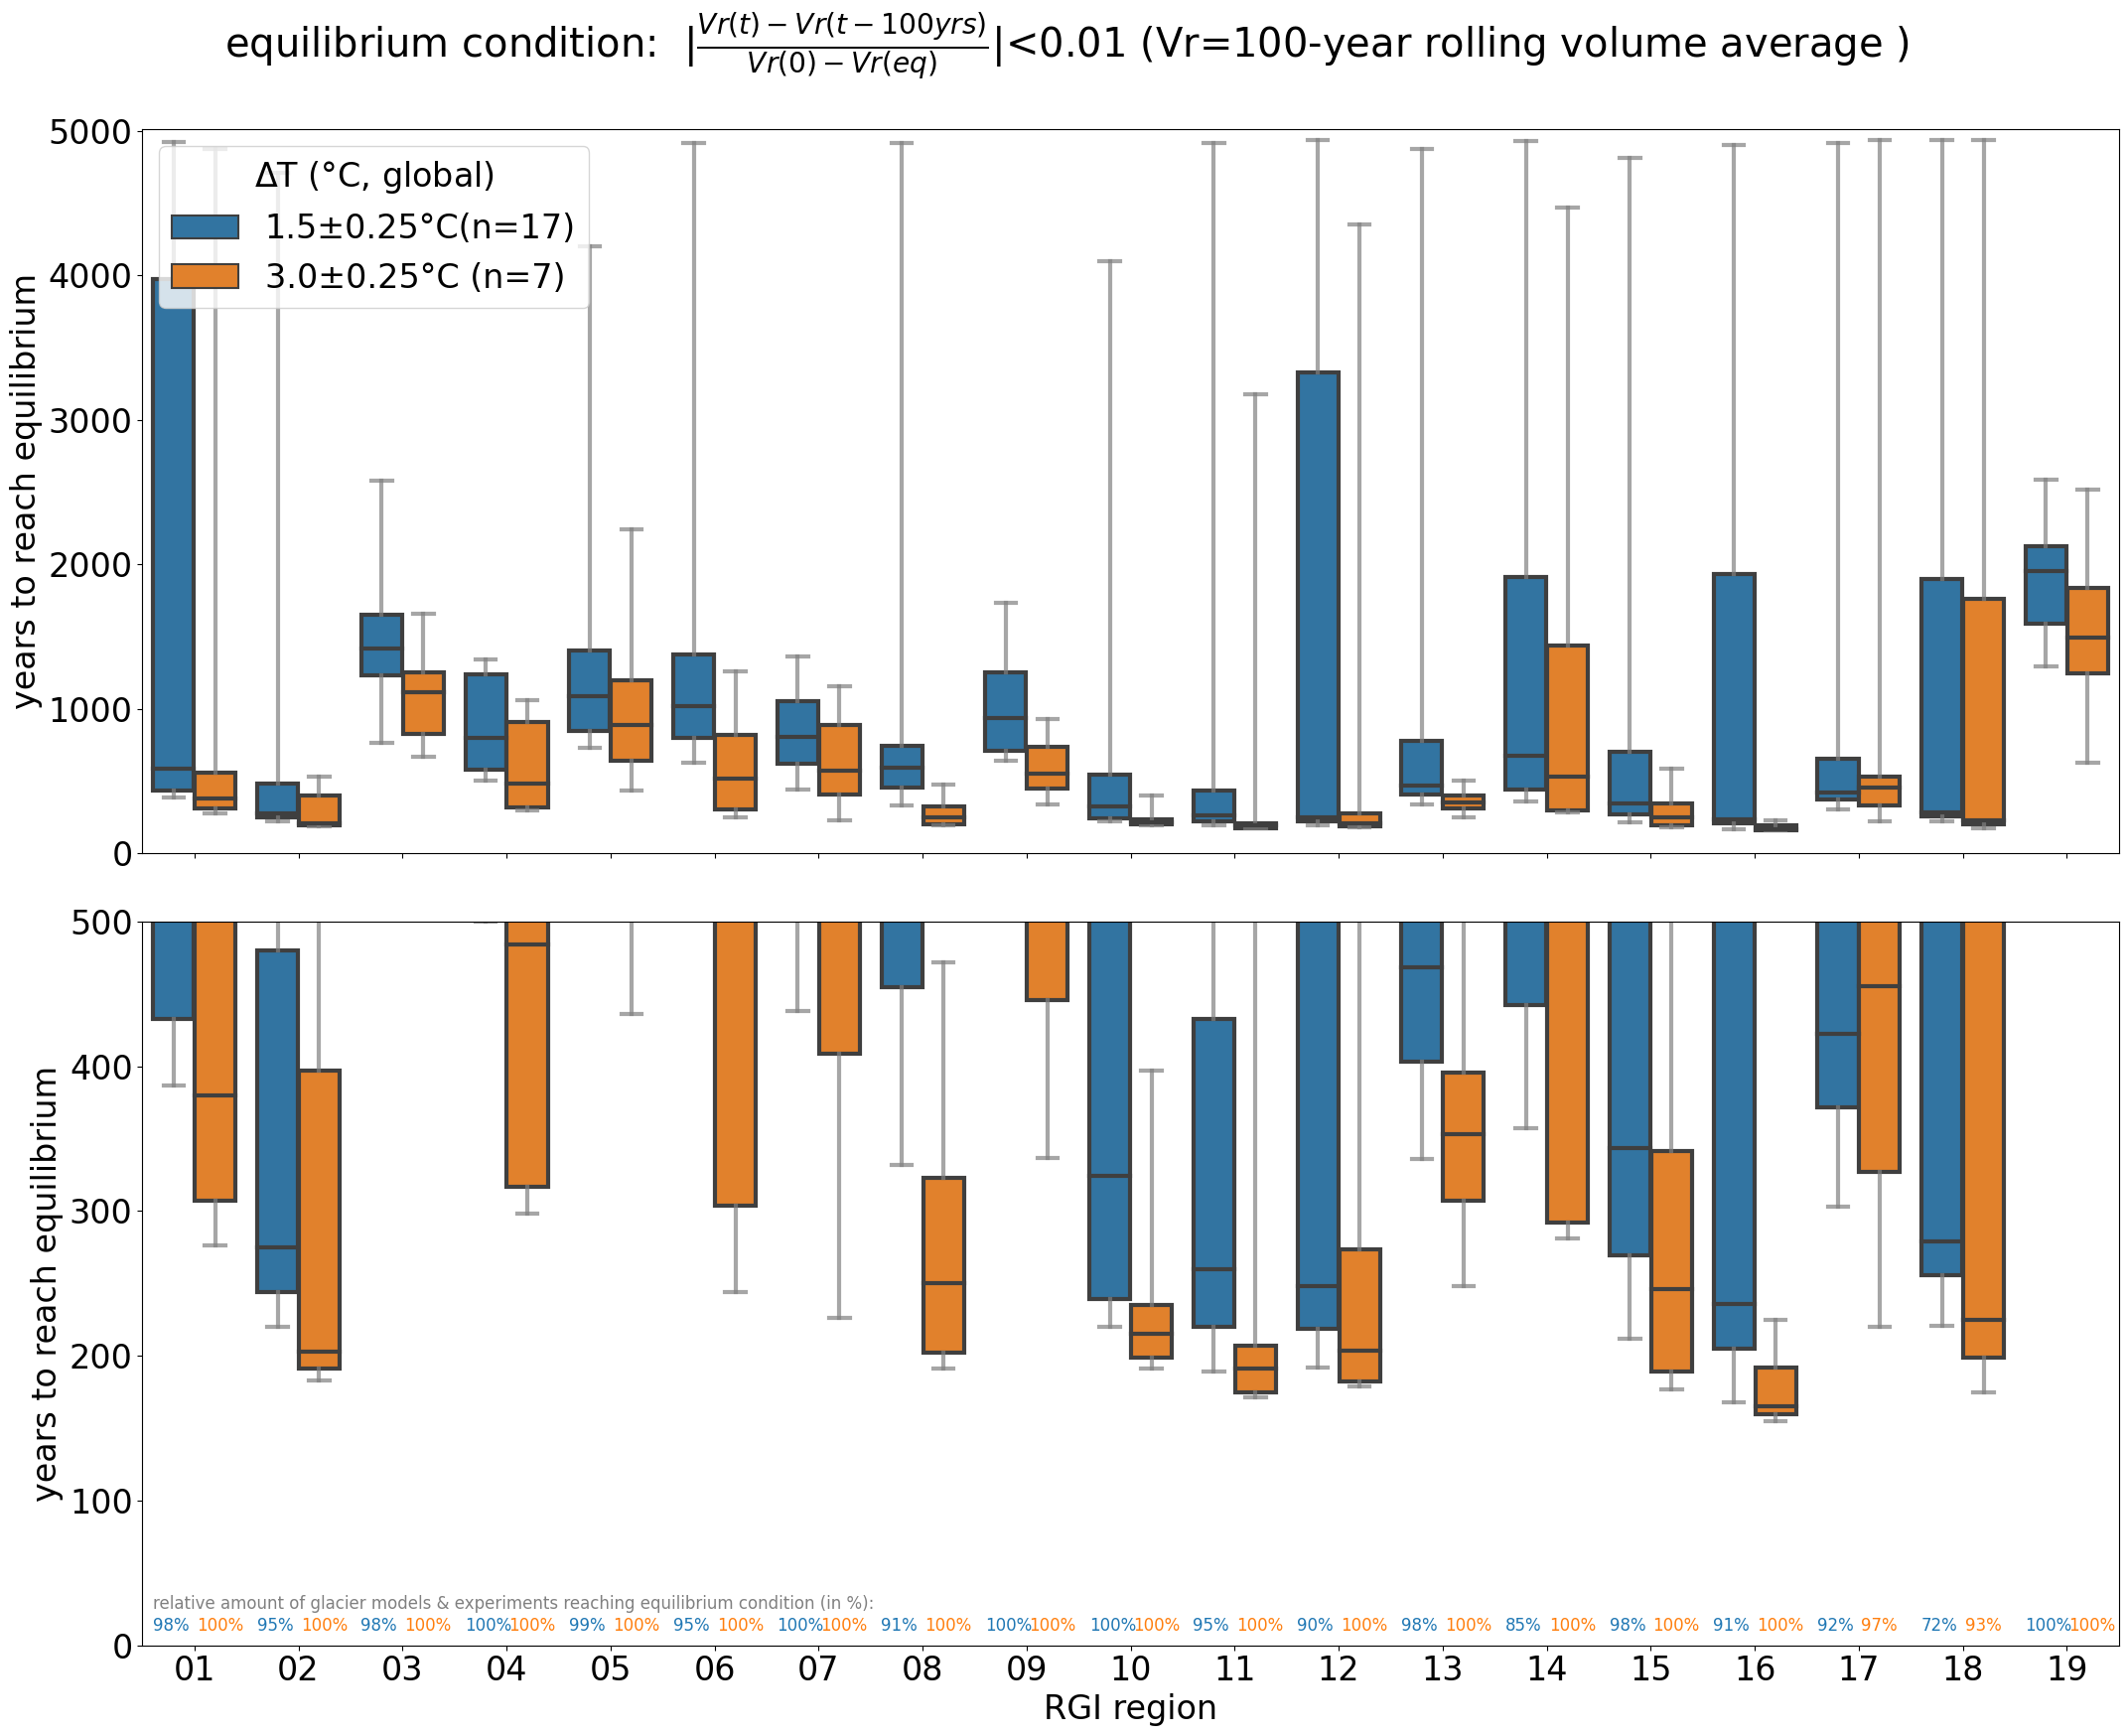

In [14]:
plt.rc('font', size=24)  

rgi_regs = ['01', '02', '03', '04', '05', '06', '07',
                   '08', '09', '10', '11', '12', '13', '14', '15',
                   '16', '17', '18', '19'] #'All',

condi15 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>1.25) & (pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc<1.75)].index
condi30 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>2.75) & (pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc<3.25)].index
n15 = len(condi15.unique())
n30 = len(condi30.unique())
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi15,'temp_ch_class'] = f'1.5±0.25°C(n={n15})'
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi30,'temp_ch_class'] = f'3.0±0.25°C (n={n30})'


fig, axs=plt.subplots(2,1,figsize=(22,18), sharex=True)
for jj,ax in enumerate(axs):
    #pd_equilibrium_yr_lower_xperc_ch_avg_yrs_f = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>=0.8]
    # only those where equilibrium is reached ...
    sns.boxplot(data=pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.simulation_yr_where_equilibrium_lower_1perc_ch_reached<=5000],
                x='rgi_reg',y='simulation_yr_where_equilibrium_lower_1perc_ch_reached',
               dodge = True, fliersize=0, whis = [5,95],  hue='temp_ch_class', hue_order = [f'1.5±0.25°C(n={n15})',f'3.0±0.25°C (n={n30})'],
                                        linewidth=3,
                                        capprops={'color':'grey', 'alpha':0.7},
                                        whiskerprops={'color':'grey', 'alpha':0.7}, ax=ax)
    ax.set_ylabel('years to reach equilibrium')

    if jj==0:
        ax.set_ylim([0,5010])
        ax.legend(loc='upper left', title=r'$\Delta$T (°C, global)')
        ax.set_xlabel('')
    else:
        ax.set_ylim([0,500])
        ax.set_xlabel('RGI region')
        ax.legend().remove()

        for j,rgi_reg in enumerate(rgi_regs):
            condi3 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.rgi_reg==rgi_reg
            _selcondi3 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi3]

            condi1_15 = _selcondi3.temp_ch_class==f'1.5±0.25°C(n={n15})'
            condi1_30 = _selcondi3.temp_ch_class==f'3.0±0.25°C (n={n30})'

            condi2 = _selcondi3.simulation_yr_where_equilibrium_lower_1perc_ch_reached<5000

            _sel = _selcondi3.loc[(condi1_30)&(condi2)]
            perc_30 = 100*len(_sel)/(len(_selcondi3.model.unique()) * n30)
            perc_30 = np.round(perc_30)

            _sel = _selcondi3.loc[(condi1_15)&(condi2)]
            perc_15 = 100*len(_sel)/(len(_selcondi3.model.unique()) * n15)
            perc_15 = np.round(perc_15)
            plt.text(-0.4+j,10,f'{perc_15:.0f}%', color=sns.color_palette()[0], fontsize=12)
            plt.text(0.02+j,10,f'{perc_30:.0f}%', color=sns.color_palette()[1], fontsize=12)
plt.text(-0.4,25, 'relative amount of glacier models & experiments reaching equilibrium condition (in %):', color='grey', fontsize=12)
if avg_yrs==20:
    plt.suptitle('equilibrium condition: '+r' $|\frac{Vr(t)-Vr(t-20yrs)}{Vr(0)-Vr(eq)}|$<0.01'+ f' (Vr={avg_yrs}-year rolling volume average )')
elif avg_yrs==60:
    plt.suptitle('equilibrium condition: '+r' $|\frac{Vr(t)-Vr(t-60yrs)}{Vr(0)-Vr(eq)}|$<0.01'+ f' (Vr={avg_yrs}-year rolling volume average )')

elif avg_yrs==100:
    plt.suptitle('equilibrium condition: '+r' $|\frac{Vr(t)-Vr(t-100yrs)}{Vr(0)-Vr(eq)}|$<0.01'+ f' (Vr={avg_yrs}-year rolling volume average )')

plt.tight_layout()
plt.savefig(f'figures/2_equilibrium_per_rgi_region_boxplots_{avg_yrs}_avg_1_5_3_0_div_total_change.png')

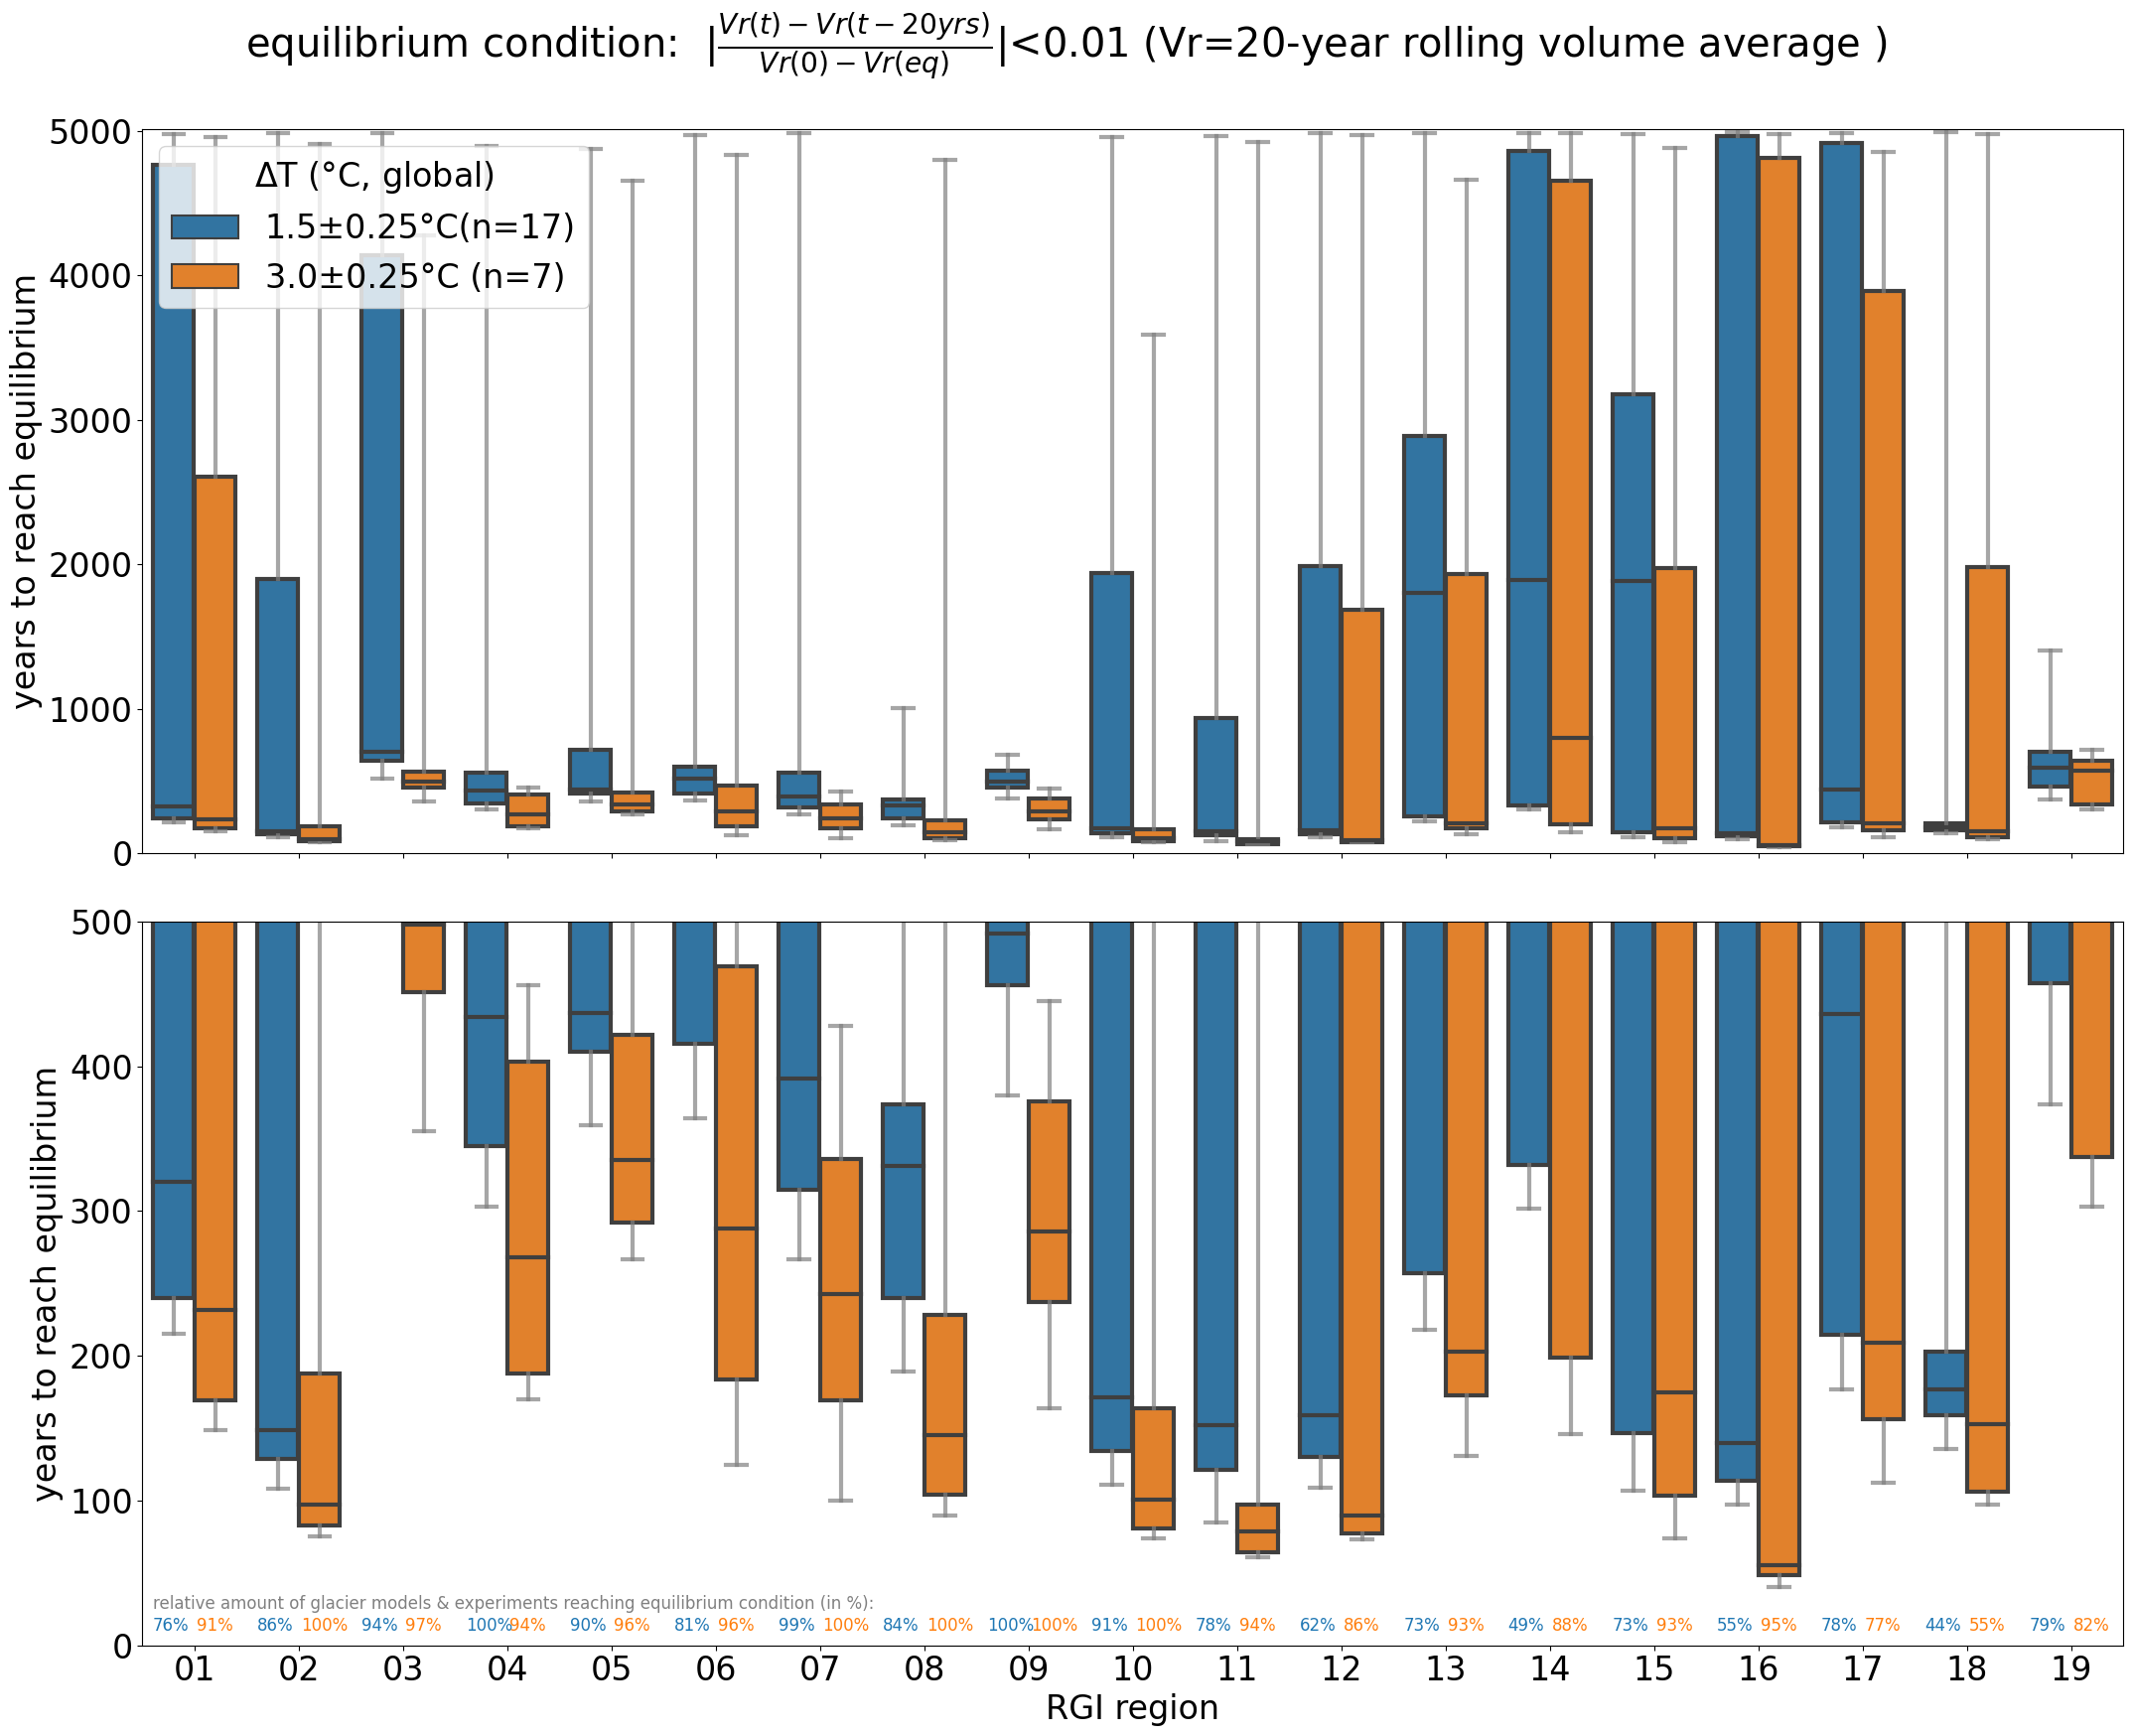

In [12]:
plt.rc('font', size=24)  

rgi_regs = ['01', '02', '03', '04', '05', '06', '07',
                   '08', '09', '10', '11', '12', '13', '14', '15',
                   '16', '17', '18', '19'] #'All',

condi15 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>1.25) & (pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc<1.75)].index
condi30 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>2.75) & (pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc<3.25)].index
n15 = len(condi15.unique())
n30 = len(condi30.unique())
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi15,'temp_ch_class'] = f'1.5±0.25°C(n={n15})'
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi30,'temp_ch_class'] = f'3.0±0.25°C (n={n30})'


fig, axs=plt.subplots(2,1,figsize=(22,18), sharex=True)
for jj,ax in enumerate(axs):
    #pd_equilibrium_yr_lower_xperc_ch_avg_yrs_f = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>=0.8]
    # only those where equilibrium is reached ...
    sns.boxplot(data=pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.simulation_yr_where_equilibrium_lower_1perc_ch_reached<=5000],
                x='rgi_reg',y='simulation_yr_where_equilibrium_lower_1perc_ch_reached',
               dodge = True, fliersize=0, whis = [5,95],  hue='temp_ch_class', hue_order = [f'1.5±0.25°C(n={n15})',f'3.0±0.25°C (n={n30})'],
                                        linewidth=3,
                                        capprops={'color':'grey', 'alpha':0.7},
                                        whiskerprops={'color':'grey', 'alpha':0.7}, ax=ax)
    ax.set_ylabel('years to reach equilibrium')

    if jj==0:
        ax.set_ylim([0,5010])
        ax.legend(loc='upper left', title=r'$\Delta$T (°C, global)')
        ax.set_xlabel('')
    else:
        ax.set_ylim([0,500])
        ax.set_xlabel('RGI region')
        ax.legend().remove()

        for j,rgi_reg in enumerate(rgi_regs):
            condi3 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.rgi_reg==rgi_reg
            _selcondi3 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi3]

            condi1_15 = _selcondi3.temp_ch_class==f'1.5±0.25°C(n={n15})'
            condi1_30 = _selcondi3.temp_ch_class==f'3.0±0.25°C (n={n30})'

            condi2 = _selcondi3.simulation_yr_where_equilibrium_lower_1perc_ch_reached<5000

            _sel = _selcondi3.loc[(condi1_30)&(condi2)]
            perc_30 = 100*len(_sel)/(len(_selcondi3.model.unique()) * n30)
            perc_30 = np.round(perc_30)

            _sel = _selcondi3.loc[(condi1_15)&(condi2)]
            perc_15 = 100*len(_sel)/(len(_selcondi3.model.unique()) * n15)
            perc_15 = np.round(perc_15)
            plt.text(-0.4+j,10,f'{perc_15:.0f}%', color=sns.color_palette()[0], fontsize=12)
            plt.text(0.02+j,10,f'{perc_30:.0f}%', color=sns.color_palette()[1], fontsize=12)
plt.text(-0.4,25, 'relative amount of glacier models & experiments reaching equilibrium condition (in %):', color='grey', fontsize=12)
if avg_yrs==20:
    plt.suptitle('equilibrium condition: '+r' $|\frac{Vr(t)-Vr(t-20yrs)}{Vr(0)-Vr(eq)}|$<0.01'+ f' (Vr={avg_yrs}-year rolling volume average )')
elif avg_yrs==60:
    plt.suptitle('equilibrium condition: '+r' $|\frac{Vr(t)-Vr(t-60yrs)}{Vr(0)-Vr(eq)}|$<0.01'+ f' (Vr={avg_yrs}-year rolling volume average )')

elif avg_yrs==100:
    plt.suptitle('equilibrium condition: '+r' $|\frac{Vr(t)-Vr(t-100yrs)}{Vr(0)-Vr(eq)}|$<0.01'+ f' (Vr={avg_yrs}-year rolling volume average )')

plt.tight_layout()
plt.savefig(f'figures/2_equilibrium_per_rgi_region_boxplots_{avg_yrs}_avg_1_5_3_0_div_total_change.png')

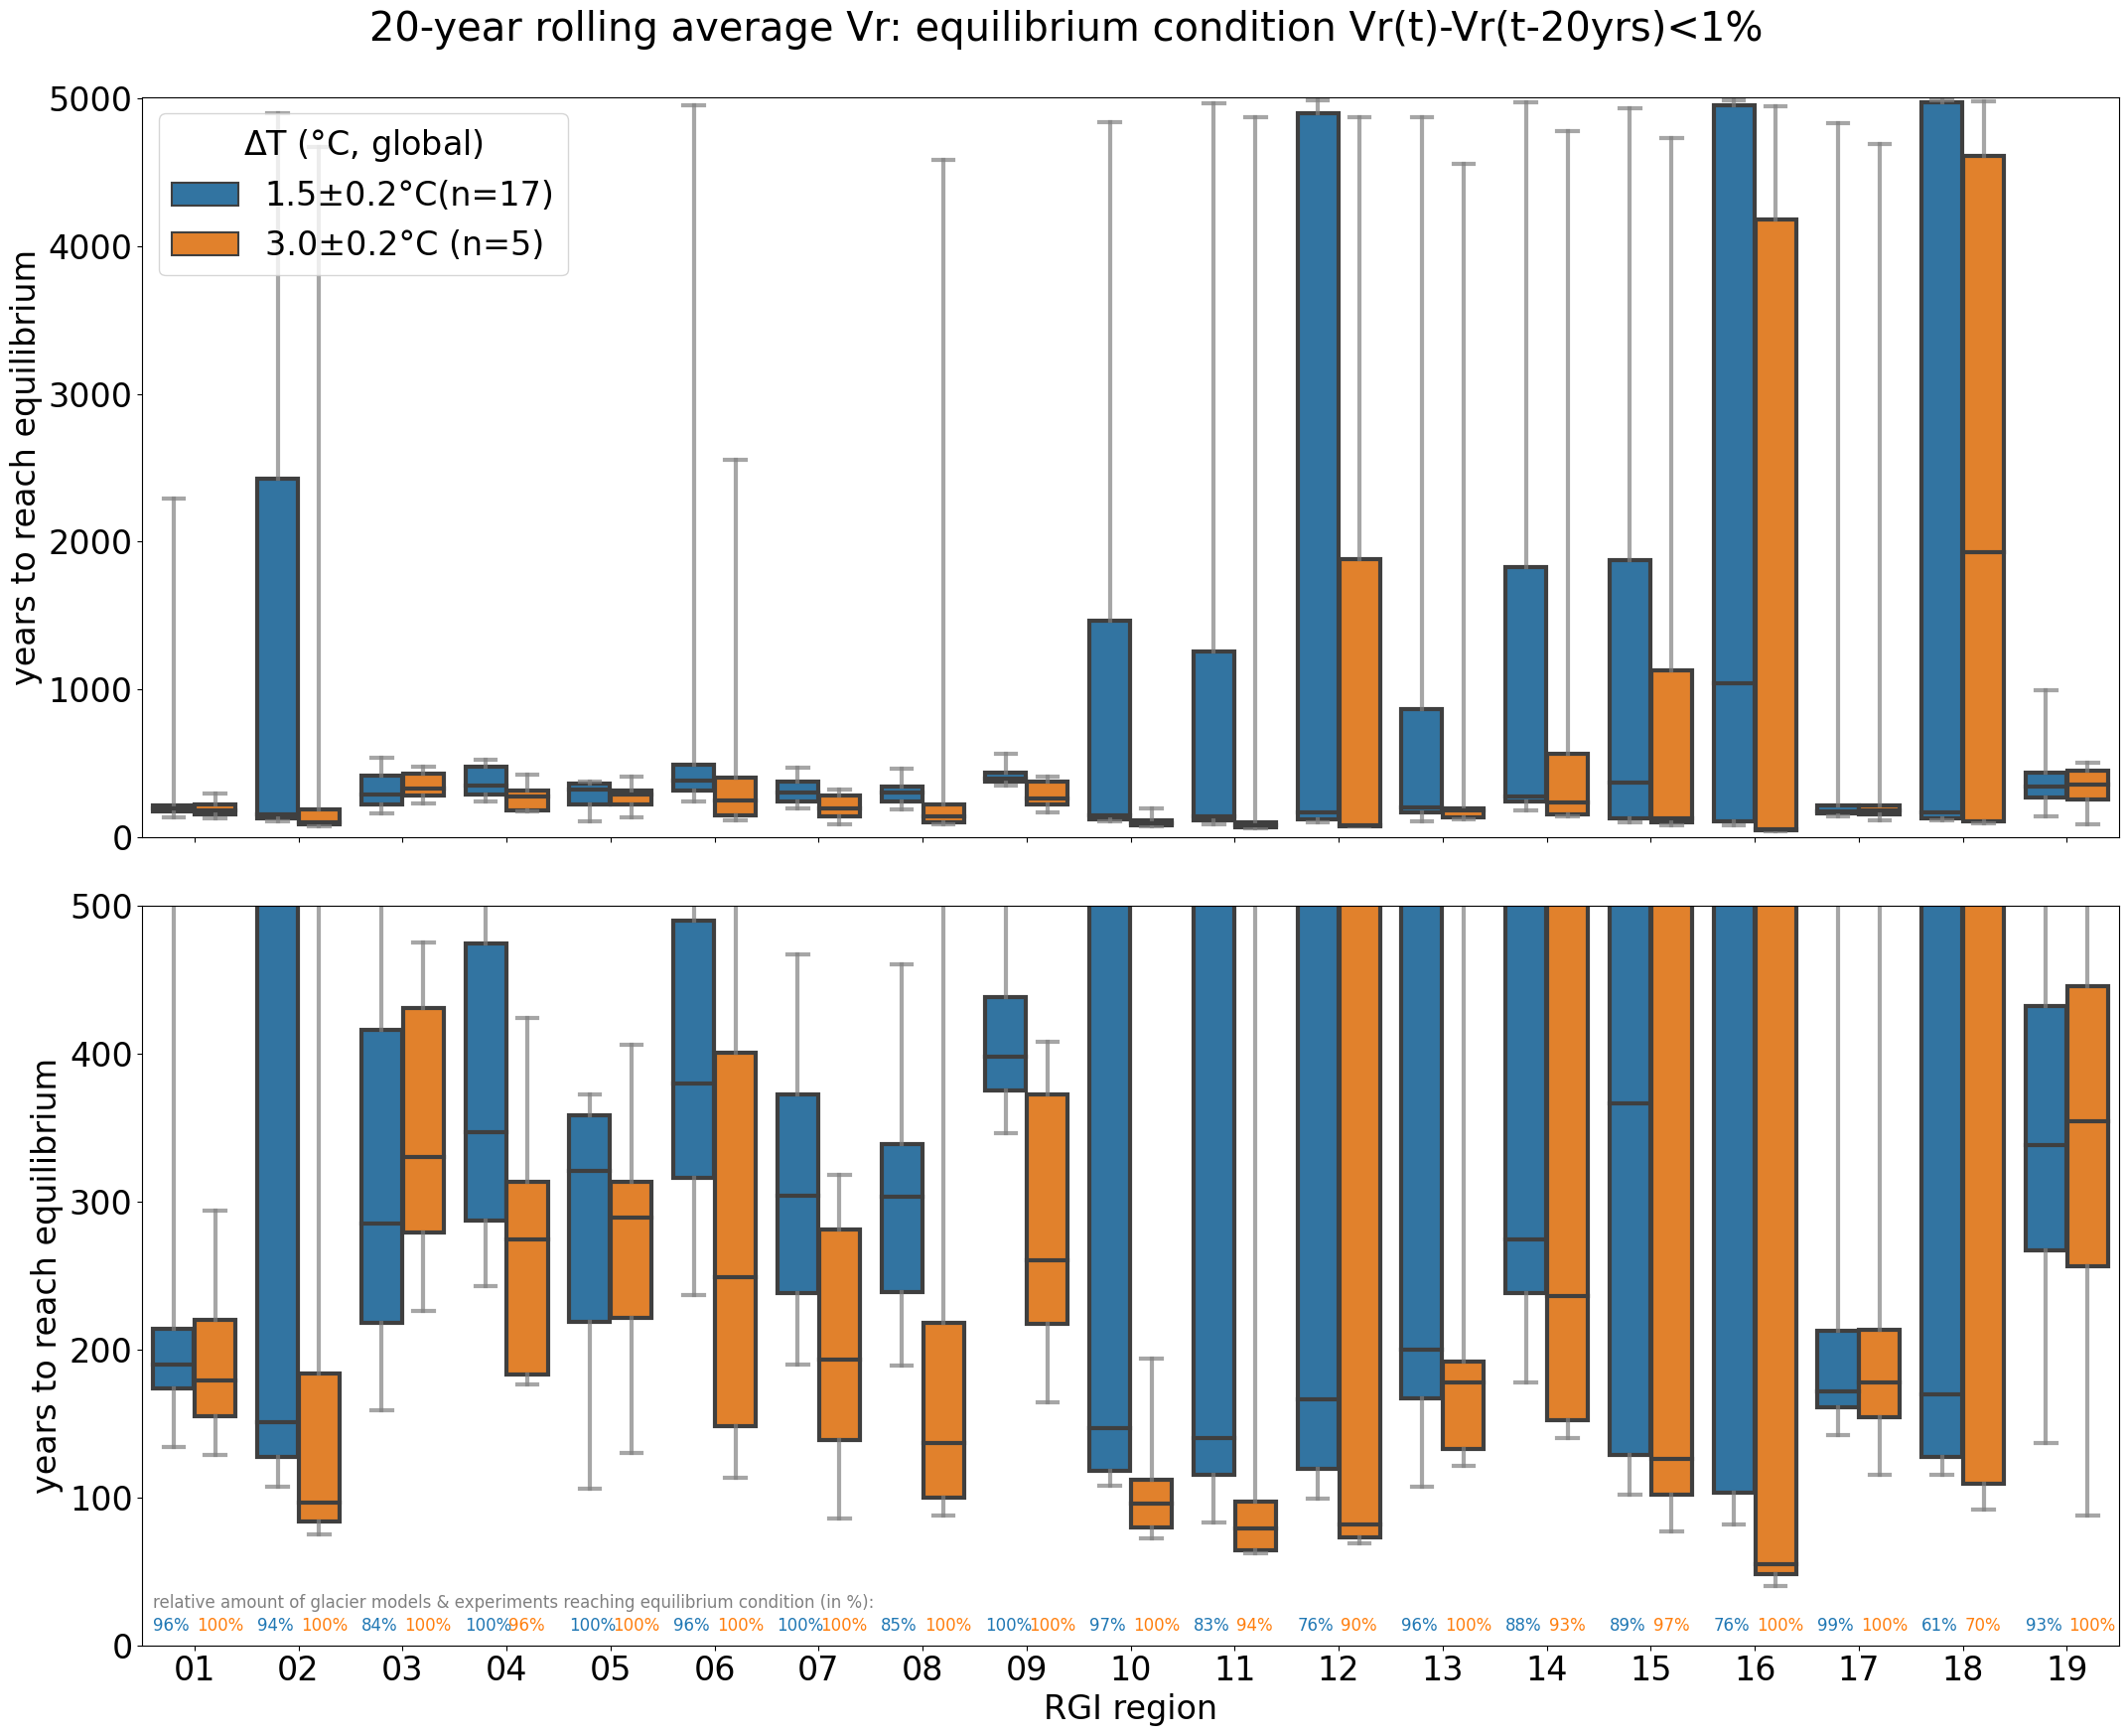

In [360]:

condi15 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>1.3) & (pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc<1.7)].index
condi30 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>2.8) & (pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc<3.2)].index
n15 = len(condi15.unique())
n30 = len(condi30.unique())
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi15,'temp_ch_class'] = f'1.5±0.2°C(n={n15})'
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi30,'temp_ch_class'] = f'3.0±0.2°C (n={n30})'


fig, axs=plt.subplots(2,1,figsize=(22,18), sharex=True)
for jj,ax in enumerate(axs):
    #pd_equilibrium_yr_lower_xperc_ch_avg_yrs_f = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>=0.8]
    # only those where equilibrium is reached ...
    sns.boxplot(data=pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.simulation_yr_where_equilibrium_lower_1perc_ch_reached<=5000],
                x='rgi_reg',y='simulation_yr_where_equilibrium_lower_1perc_ch_reached',
               dodge = True, fliersize=0, whis = [5,95],  hue='temp_ch_class', hue_order = [f'1.5±0.2°C(n={n15})',f'3.0±0.2°C (n={n30})'],
                                        linewidth=3,
                                        capprops={'color':'grey', 'alpha':0.7},
                                        whiskerprops={'color':'grey', 'alpha':0.7}, ax=ax)
    ax.set_ylabel('years to reach equilibrium')

    if jj==0:
        ax.set_ylim([0,5010])
        ax.legend(loc='upper left', title=r'$\Delta$T (°C, global)')
        ax.set_xlabel('')
    else:
        ax.set_ylim([0,500])
        ax.set_xlabel('RGI region')
        ax.legend().remove()

        for j,rgi_reg in enumerate(rgi_regs):
            condi3 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.rgi_reg==rgi_reg
            _selcondi3 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi3]

            condi1_15 = _selcondi3.temp_ch_class==f'1.5±0.2°C(n={n15})'
            condi1_30 = _selcondi3.temp_ch_class==f'3.0±0.2°C (n={n30})'

            condi2 = _selcondi3.simulation_yr_where_equilibrium_lower_1perc_ch_reached<5000

            _sel = _selcondi3.loc[(condi1_30)&(condi2)]
            perc_30 = 100*len(_sel)/(len(_selcondi3.model.unique()) * n30)
            perc_30 = np.round(perc_30)

            _sel = _selcondi3.loc[(condi1_15)&(condi2)]
            perc_15 = 100*len(_sel)/(len(_selcondi3.model.unique()) * n15)
            perc_15 = np.round(perc_15)
            plt.text(-0.4+j,10,f'{perc_15:.0f}%', color=sns.color_palette()[0], fontsize=12)
            plt.text(0.02+j,10,f'{perc_30:.0f}%', color=sns.color_palette()[1], fontsize=12)
plt.text(-0.4,25, 'relative amount of glacier models & experiments reaching equilibrium condition (in %):', color='grey', fontsize=12)
plt.suptitle(f'{avg_yrs}-year rolling average Vr: equilibrium condition Vr(t)-Vr(t-{avg_yrs}yrs)<1%')
plt.tight_layout()
plt.savefig(f'figures/2_equilibrium_per_rgi_region_boxplots_{avg_yrs}_avg_1_5_3_0.png')

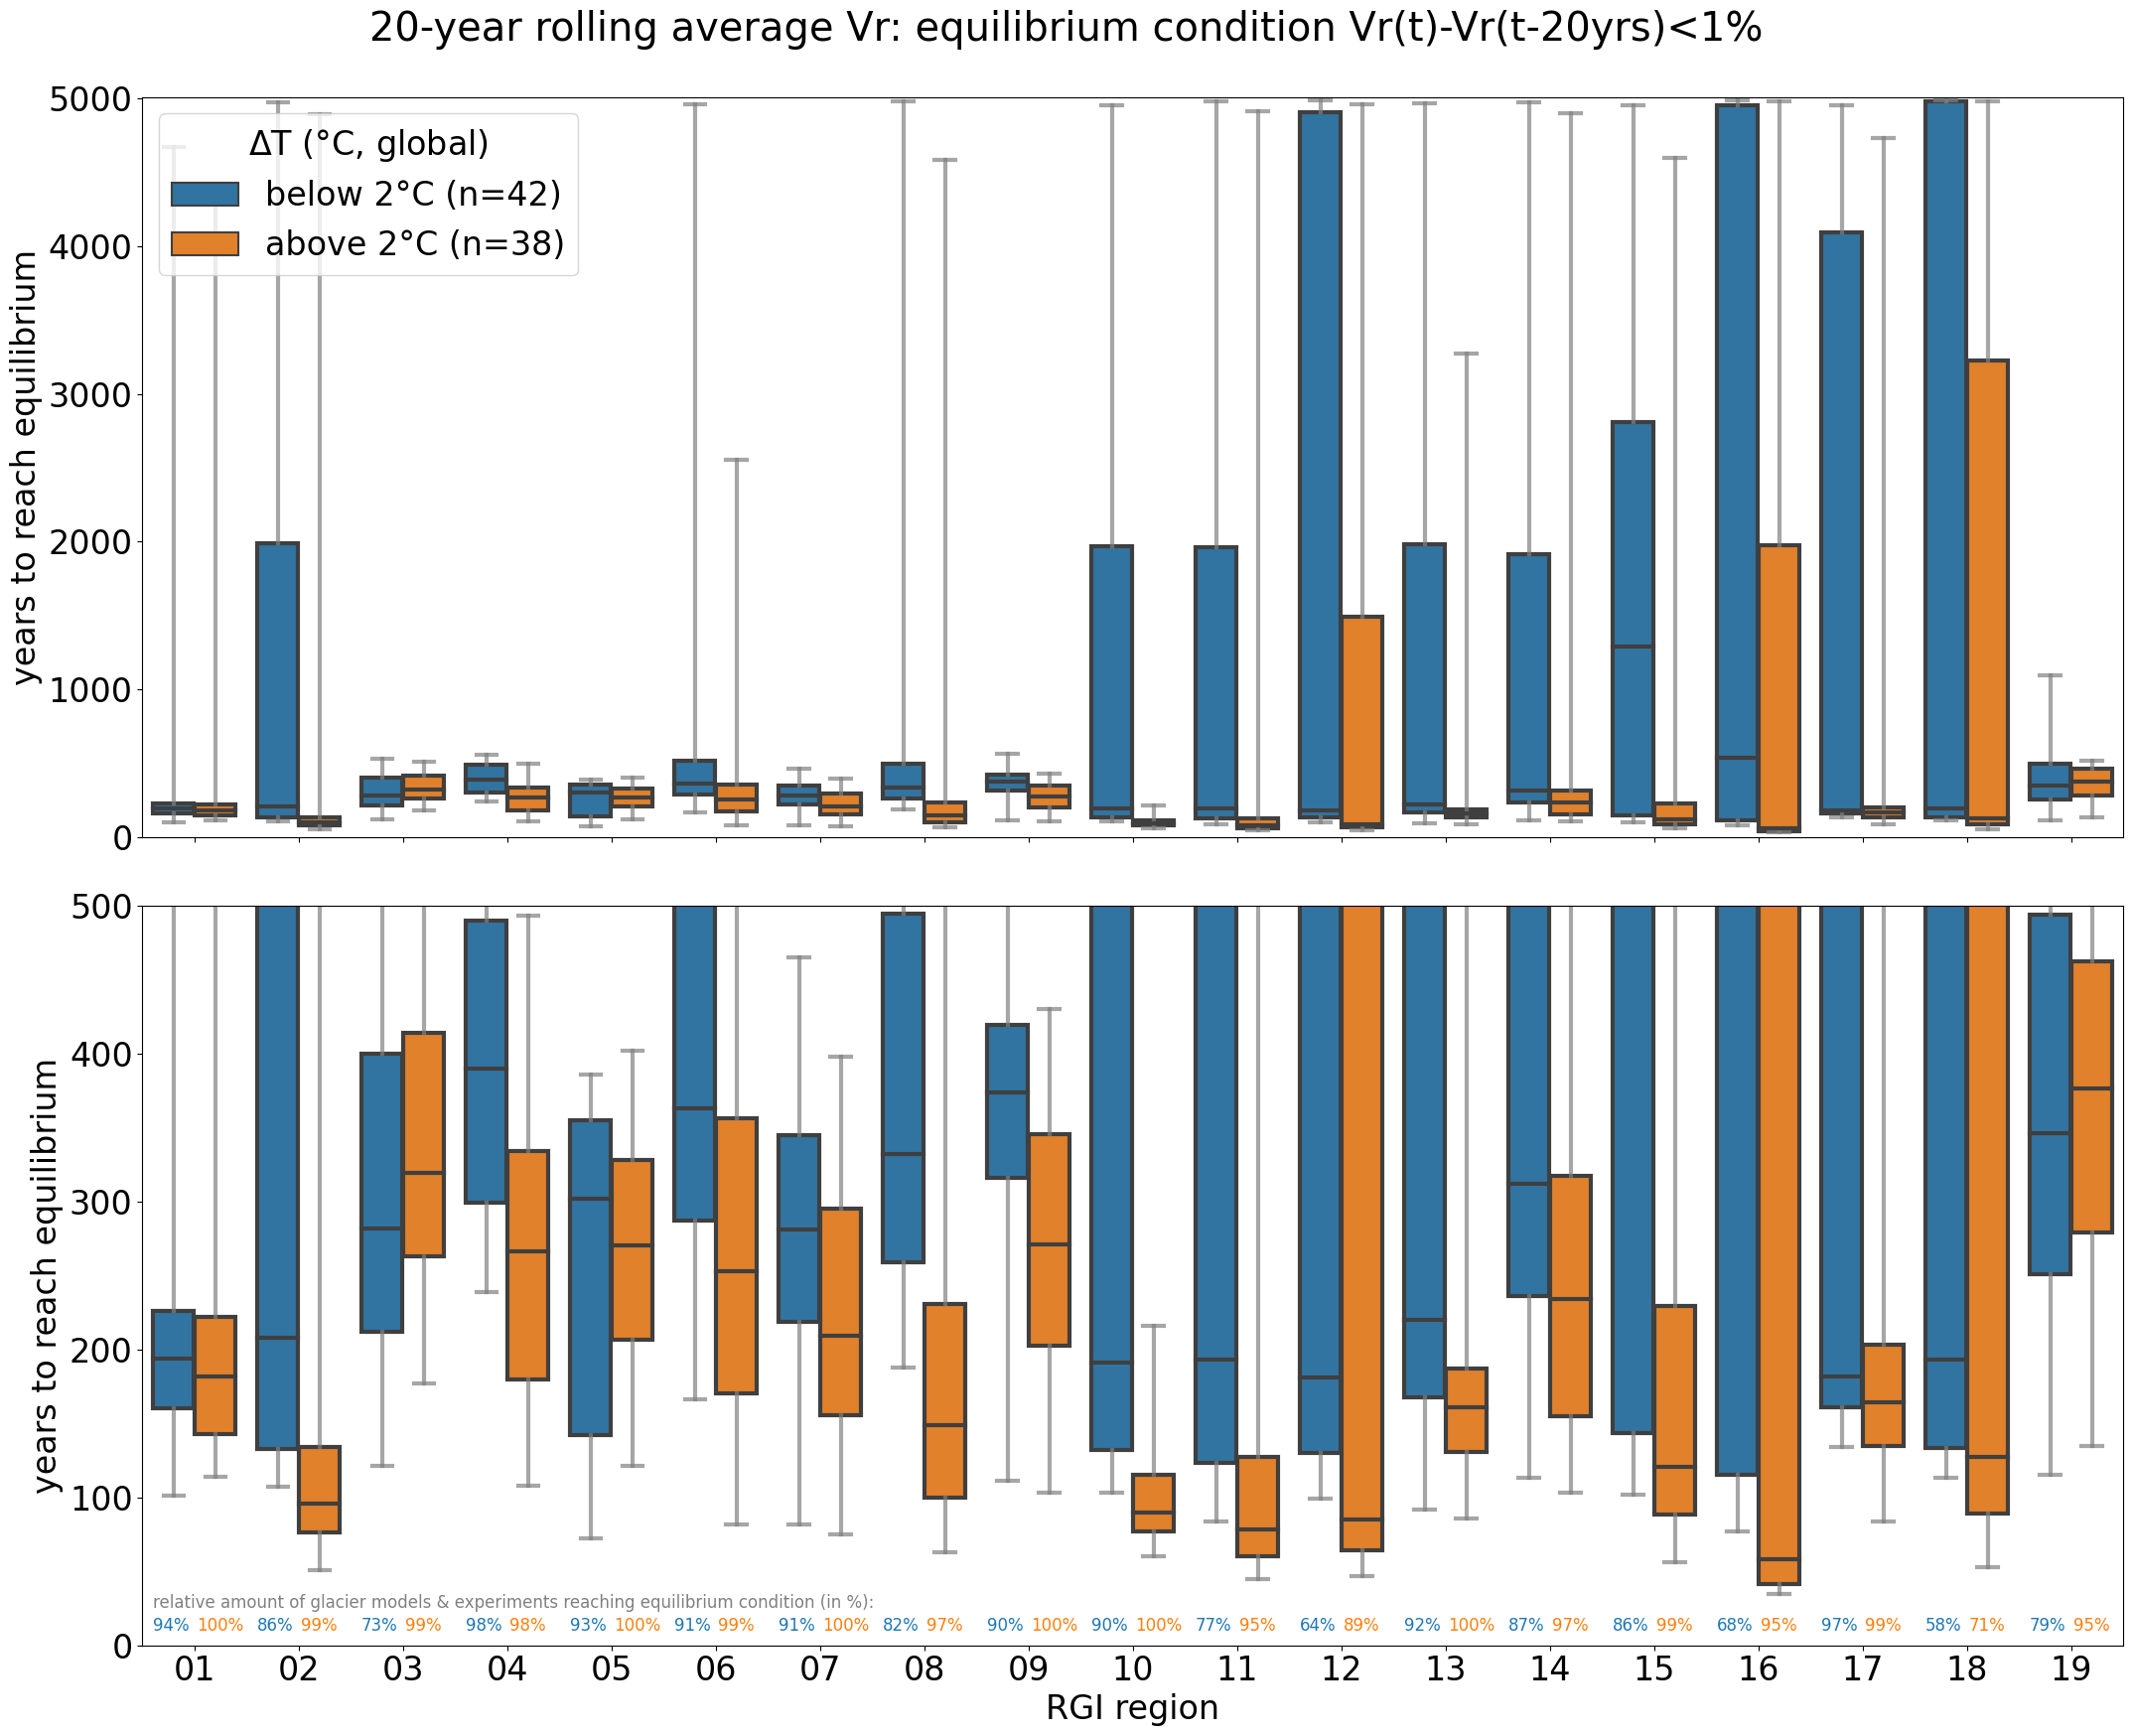

In [334]:
nbelow = len(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs['temp_ch_ipcc']<2].index.unique())
nabove = len(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs['temp_ch_ipcc']>2].index.unique())

pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs['temp_ch_ipcc']>2,'temp_ch_class'] = f'above 2°C (n={nabove})'
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs['temp_ch_ipcc']<2,'temp_ch_class'] = f'below 2°C (n={nbelow})'

fig, axs=plt.subplots(2,1,figsize=(22,18), sharex=True)
for jj,ax in enumerate(axs):
    #pd_equilibrium_yr_lower_xperc_ch_avg_yrs_f = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>=0.8]
    # only those where equilibrium is reached ...
    sns.boxplot(data=pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.simulation_yr_where_equilibrium_lower_1perc_ch_reached<=5000],
                x='rgi_reg',y='simulation_yr_where_equilibrium_lower_1perc_ch_reached',
               dodge = True, fliersize=0, whis = [5,95],  hue='temp_ch_class', hue_order = [f'below 2°C (n={nbelow})',f'above 2°C (n={nabove})'],
                                        linewidth=3,
                                        capprops={'color':'grey', 'alpha':0.7},
                                        whiskerprops={'color':'grey', 'alpha':0.7}, ax=ax)
    ax.set_ylabel('years to reach equilibrium')

    if jj==0:
        ax.set_ylim([0,5010])
        ax.legend(loc='upper left', title=r'$\Delta$T (°C, global)')
        ax.set_xlabel('')
    else:
        ax.set_ylim([0,500])
        ax.set_xlabel('RGI region')
        ax.legend().remove()

        for j,rgi_reg in enumerate(rgi_regs):
            condi3 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.rgi_reg==rgi_reg
            _selcondi3 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi3]

            condi1a = _selcondi3.temp_ch_class==f'above 2°C (n={nabove})'
            condi1b = _selcondi3.temp_ch_class==f'below 2°C (n={nbelow})'
            condi2 = _selcondi3.simulation_yr_where_equilibrium_lower_1perc_ch_reached<5000

            _sel = _selcondi3.loc[(condi1a)&(condi2)]
            perc_above = 100*len(_sel)/(len(_selcondi3.model.unique()) * nabove)
            perc_above = np.round(perc_above)

            _sel = _selcondi3.loc[(condi1b)&(condi2)]
            perc_below = 100*len(_sel)/(len(_selcondi3.model.unique()) * nbelow)
            perc_below = np.round(perc_below)
            plt.text(-0.4+j,10,f'{perc_below:.0f}%', color=sns.color_palette()[0], fontsize=12)
            plt.text(0.02+j,10,f'{perc_above:.0f}%', color=sns.color_palette()[1], fontsize=12)
plt.text(-0.4,25, 'relative amount of glacier models & experiments reaching equilibrium condition (in %):', color='grey', fontsize=12)
plt.suptitle(f'{avg_yrs}-year rolling average Vr: equilibrium condition Vr(t)-Vr(t-{avg_yrs}yrs)<1%')
plt.tight_layout()
plt.savefig(f'figures/2_equilibrium_per_rgi_region_boxplots_{avg_yrs}_avg.png')

- We show the distribution of years where equilibrium is reached, i.e. in the idealised case the amount of experiments times the amount of models for that region
    - however, there are some models & experiments, where no equilibrium is reached (either because we would need to run longer, or because there is a large interannual variability). Therefore, we added the percentage of experiments & models where the equilibrium year could be estimated ... 
    - divided into experiments below and above 2°C global warming with respectively 42 or 38 experiments. 

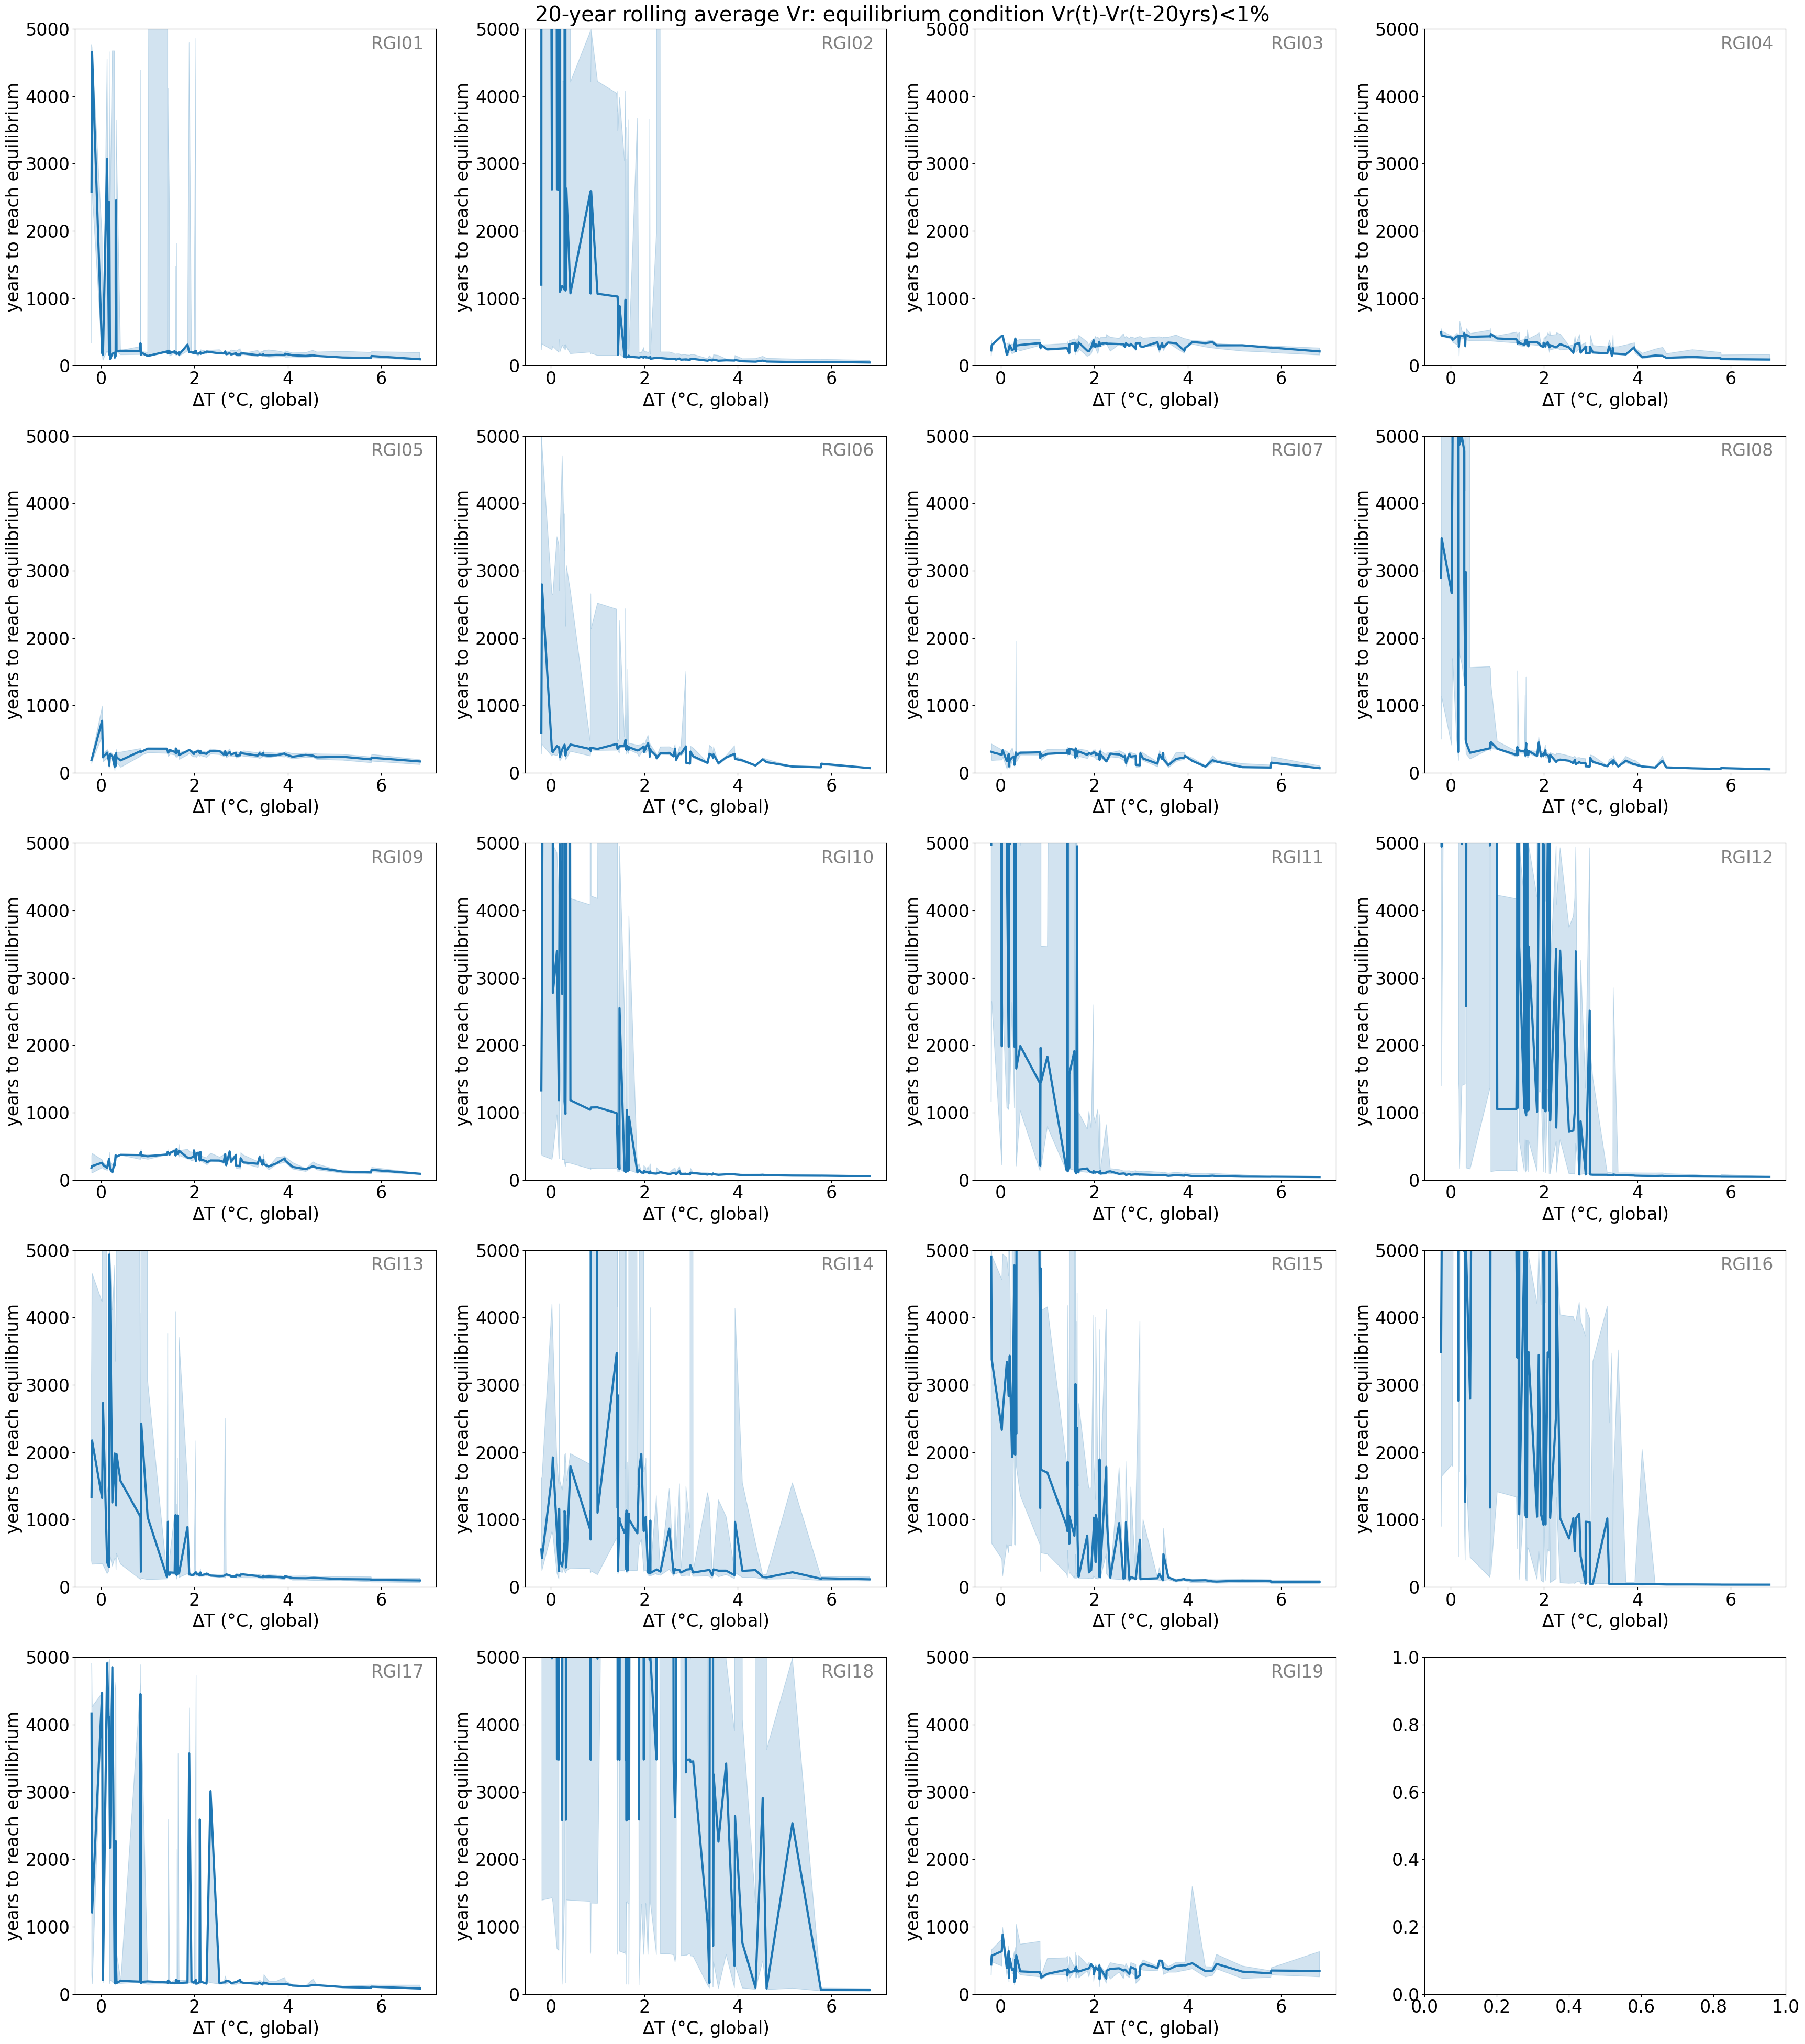

In [335]:
plt.rc('font', size=24)  

rgi_regs = ['01', '02', '03', '04', '05', '06', '07',
                   '08', '09', '10', '11', '12', '13', '14', '15',
                   '16', '17', '18', '19'] #'All',
fig, axs = plt.subplots(5,4,figsize=(35,40)) #, sharey='row') #, sharex=True)

for j, rgi_reg in enumerate(rgi_regs):
    if j<4:
        ax = axs[0][j]
    elif j <8:
        ax = axs[1][j-4]
    elif j <12:
        ax = axs[2][j-8]
    elif j <16:
        ax = axs[3][j-12]
    elif j <20:
        ax = axs[4][j-16]
    pd_equilibrium_yr_lower_xperc_ch_avg_yrs_reg = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.rgi_reg==rgi_reg]
    #pd_equilibrium_yr_lower_xperc_ch_avg_yrs_reg_f = pd_equilibrium_yr_lower_xperc_ch_avg_yrs_reg.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs_reg.temp_ch_ipcc>=1.1]
    sns.lineplot(data=pd_equilibrium_yr_lower_xperc_ch_avg_yrs_reg, y='simulation_yr_where_equilibrium_lower_1perc_ch_reached',
                 x='temp_ch_ipcc', estimator='median', errorbar=('pi', 50), ax=ax, lw=3)
    ax.text(0.82, 0.94, f'RGI{rgi_reg}', color='grey',transform=ax.transAxes, fontsize=24)

    ax.set_ylim([0,5000])
    ax.set_ylabel('years to reach equilibrium')
    ax.set_xlabel(r'$\Delta$T (°C, global)')

plt.suptitle(f'{avg_yrs}-year rolling average Vr: equilibrium condition Vr(t)-Vr(t-{avg_yrs}yrs)<1%')
plt.tight_layout()

In [165]:
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.groupby('rgi_reg').min()

,gcm,period_scenario,simulation_yr_where_equilibrium_lower_1perc_ch_reached,temp_ch_ipcc,model
rgi_reg,,,,,
01,gfdl-esm4,1851-1870_hist,57,-0.203529,Compagno
02,gfdl-esm4,1851-1870_hist,42,-0.203529,Compagno
03,gfdl-esm4,1851-1870_hist,59,-0.203529,Compagno
04,gfdl-esm4,1851-1870_hist,61,-0.203529,Compagno
05,gfdl-esm4,1851-1870_hist,33,-0.203529,GLIMB
06,gfdl-esm4,1851-1870_hist,32,-0.203529,Compagno
07,gfdl-esm4,1851-1870_hist,37,-0.203529,Compagno
08,gfdl-esm4,1851-1870_hist,48,-0.203529,Compagno
09,gfdl-esm4,1851-1870_hist,39,-0.203529,Compagno


In [82]:
pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.sort_values(by='simulation_yr_where_equilibrium_lower_1perc_ch_reached')

In [85]:
pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.dropna()

In [88]:
pd_equilibrium_yr_lower_xperc_ch_avg_yrs

simulation_yr_where_equilibrium_lower_1perc_ch_reached  \
gcm           period_scenario                                                           
ukesm1-0-ll   2081-2100_ssp585                                                152       
ipsl-cm6a-lr  2081-2100_ssp370                                                152       
ukesm1-0-ll   2081-2100_ssp585                                                152       
ipsl-cm6a-lr  2081-2100_ssp585                                                152       
ukesm1-0-ll   2081-2100_ssp370                                                152       
...                                                                           ...       
mpi-esm1-2-hr 1951-1970_hist                                               100001       
              2021-2040_ssp585                                             100001       
              2021-2040_ssp585                                             100001       
mri-esm2-0    1951-1970_hist                                               100001       
ukesm1-0-ll   1901-1920_hist                                               100001       

                               rgi_reg      model  
gcm           period_scenario                      
ukesm1-0-ll   2081-2100_ssp585      16   Compagno  
ipsl-cm6a-lr  2081-2100_ssp370      16   OGGM_v16  
ukesm1-0-ll   2081-2100_ssp585      16  Zekollari  
ipsl-cm6a-lr  2081-2100_ssp585      16   Compagno  
ukesm1-0-ll   2081-2100_ssp370      16   OGGM_v16  
...                                ...        ...  
mpi-esm1-2-hr 1951-1970_hist        12   OGGM-VAS  
              2021-2040_ssp585      12   OGGM-VAS  
              2021-2040_ssp585      12   OGGM_v16  
mri-esm2-0    1951-1970_hist        08   OGGM_v16  
ukesm1-0-ll   1901-1920_hist        16   OGGM-VAS  

[8412 rows x 3 columns]

In [86]:
# check the regions that are mostly not in equilibrium 
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.simulation_yr_where_equilibrium_lower_1perc_ch_reached ==100001]#.groupby('rgi_reg').count()

simulation_yr_where_equilibrium_lower_1perc_ch_reached  \
gcm           period_scenario                                                           
mpi-esm1-2-hr 1951-1970_hist                                               100001       
gfdl-esm4     1951-1970_hist                                               100001       
ukesm1-0-ll   2061-2080_ssp126                                             100001       
              1951-1970_hist                                               100001       
gfdl-esm4     1995-2014_hist                                               100001       
...                                                                           ...       
mpi-esm1-2-hr 1951-1970_hist                                               100001       
              2021-2040_ssp585                                             100001       
              2021-2040_ssp585                                             100001       
mri-esm2-0    1951-1970_hist                                               100001       
ukesm1-0-ll   1901-1920_hist                                               100001       

                               rgi_reg     model  
gcm           period_scenario                     
mpi-esm1-2-hr 1951-1970_hist        08  OGGM_v16  
gfdl-esm4     1951-1970_hist        18  OGGM_v16  
ukesm1-0-ll   2061-2080_ssp126      18  OGGM-VAS  
              1951-1970_hist        16  OGGM-VAS  
gfdl-esm4     1995-2014_hist        16     GLIMB  
...                                ...       ...  
mpi-esm1-2-hr 1951-1970_hist        12  OGGM-VAS  
              2021-2040_ssp585      12  OGGM-VAS  
              2021-2040_ssp585      12  OGGM_v16  
mri-esm2-0    1951-1970_hist        08  OGGM_v16  
ukesm1-0-ll   1901-1920_hist        16  OGGM-VAS  

[80 rows x 3 columns]

In [87]:
# check the experiments that are mostly not in equilibrium 
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.simulation_yr_where_equilibrium_lower_1perc_ch_reached ==100001].reset_index().groupby('period_scenario').count()

,gcm,simulation_yr_where_equilibrium_lower_1perc_ch_reached,rgi_reg,model
period_scenario,,,,
1851-1870_hist,28,28,28,28
1901-1920_hist,16,16,16,16
1951-1970_hist,23,23,23,23
1995-2014_hist,4,4,4,4
2021-2040_ssp370,1,1,1,1
2021-2040_ssp585,3,3,3,3
2041-2060_ssp126,2,2,2,2
2041-2060_ssp370,1,1,1,1
2061-2080_ssp126,2,2,2,2


In [53]:
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.dropna()

simulation_yr_where_equilibrium_lower_1perc_ch_reached  \
gcm           period_scenario                                                           
mpi-esm1-2-hr 1995-2014_hist                                                   32       
ukesm1-0-ll   1851-1870_hist                                                   33       
              2081-2100_ssp585                                                 33       
              2081-2100_ssp585                                                 33       
ipsl-cm6a-lr  2081-2100_ssp585                                                 34       
...                                                                           ...       
ukesm1-0-ll   2021-2040_ssp585                                             100001       
gfdl-esm4     1851-1870_hist                                               100001       
              1901-1920_hist                                               100001       
              2021-2040_ssp585                                             100001       
              2041-2060_ssp370                                             100001       

                               rgi_reg      model  
gcm           period_scenario                      
mpi-esm1-2-hr 1995-2014_hist        06  Zekollari  
ukesm1-0-ll   1851-1870_hist        05   OGGM-VAS  
              2081-2100_ssp585      16   Compagno  
              2081-2100_ssp585      16   OGGM_v16  
ipsl-cm6a-lr  2081-2100_ssp585      16   OGGM_v16  
...                                ...        ...  
ukesm1-0-ll   2021-2040_ssp585      16   OGGM-VAS  
gfdl-esm4     1851-1870_hist        16      GLIMB  
              1901-1920_hist        16      GLIMB  
              2021-2040_ssp585      16      GLIMB  
              2041-2060_ssp370      16   OGGM_v16  

[8297 rows x 3 columns]

simulation_yr_where_equilibrium_lower_1perc_ch_reached  \
gcm           period_scenario                                                           
mpi-esm1-2-hr 1901-1920_hist                                               100001       
ipsl-cm6a-lr  2081-2100_ssp126                                             100001       
gfdl-esm4     2081-2100_ssp126                                             100001       
              1901-1920_hist                                               100001       
              2041-2060_ssp585                                             100001       
...                                                                           ...       
              2041-2060_ssp585                                             100001       
              2041-2060_ssp370                                             100001       
ukesm1-0-ll   1851-1870_hist                                               100001       
mri-esm2-0    2081-2100_ssp585                                             100001       
gfdl-esm4     2041-2060_ssp370                                             100001       

                               rgi_reg     model  
gcm           period_scenario                     
mpi-esm1-2-hr 1901-1920_hist        08  OGGM_v16  
ipsl-cm6a-lr  2081-2100_ssp126      04  Compagno  
gfdl-esm4     2081-2100_ssp126      11  Compagno  
              1901-1920_hist        08  OGGM-VAS  
              2041-2060_ssp585      14  Compagno  
...                                ...       ...  
              2041-2060_ssp585      18  Compagno  
              2041-2060_ssp370      18  Compagno  
ukesm1-0-ll   1851-1870_hist        11  Compagno  
mri-esm2-0    2081-2100_ssp585      18  OGGM-VAS  
gfdl-esm4     2041-2060_ssp370      18  OGGM-VAS  

[603 rows x 3 columns]

In [57]:
# check the regions that are mostly not in equilibrium 
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.simulation_yr_where_equilibrium_lower_1perc_ch_reached ==100001]#.groupby('rgi_reg').count()

simulation_yr_where_equilibrium_lower_1perc_ch_reached  \
gcm           period_scenario                                                           
ipsl-cm6a-lr  2021-2040_ssp370                                             100001       
              2061-2080_ssp126                                             100001       
              1901-1920_hist                                               100001       
mri-esm2-0    1901-1920_hist                                               100001       
mpi-esm1-2-hr 2021-2040_ssp585                                             100001       
...                                                                           ...       
              2021-2040_ssp585                                             100001       
              2041-2060_ssp126                                             100001       
              2041-2060_ssp370                                             100001       
              1851-1870_hist                                               100001       
              2021-2040_ssp126                                             100001       

                               rgi_reg     model  
gcm           period_scenario                     
ipsl-cm6a-lr  2021-2040_ssp370      11  OGGM-VAS  
              2061-2080_ssp126      11  OGGM-VAS  
              1901-1920_hist        11  OGGM-VAS  
mri-esm2-0    1901-1920_hist        10  OGGM_v16  
mpi-esm1-2-hr 2021-2040_ssp585      11  OGGM-VAS  
...                                ...       ...  
              2021-2040_ssp585      18  OGGM-VAS  
              2041-2060_ssp126      18  OGGM-VAS  
              2041-2060_ssp370      18  OGGM-VAS  
              1851-1870_hist        18  OGGM-VAS  
              2021-2040_ssp126      16  OGGM_v16  

[523 rows x 3 columns]

In [36]:
pd_equilibrium_yr_lower_xperc_ch.dropna()

simulation_yr_where_equilibrium_lower_1perc_ch_reached  \
gcm           period_scenario                                                           
mpi-esm1-2-hr 1995-2014_hist                                                   32       
ukesm1-0-ll   1851-1870_hist                                                   33       
              2081-2100_ssp585                                                 33       
              2081-2100_ssp585                                                 33       
ipsl-cm6a-lr  2081-2100_ssp585                                                 34       
...                                                                           ...       
ukesm1-0-ll   2021-2040_ssp585                                             100001       
gfdl-esm4     1851-1870_hist                                               100001       
              1901-1920_hist                                               100001       
              2021-2040_ssp585                                             100001       
              2041-2060_ssp370                                             100001       

                               rgi_reg      model  
gcm           period_scenario                      
mpi-esm1-2-hr 1995-2014_hist        06  Zekollari  
ukesm1-0-ll   1851-1870_hist        05   OGGM-VAS  
              2081-2100_ssp585      16   Compagno  
              2081-2100_ssp585      16   OGGM_v16  
ipsl-cm6a-lr  2081-2100_ssp585      16   OGGM_v16  
...                                ...        ...  
ukesm1-0-ll   2021-2040_ssp585      16   OGGM-VAS  
gfdl-esm4     1851-1870_hist        16      GLIMB  
              1901-1920_hist        16      GLIMB  
              2021-2040_ssp585      16      GLIMB  
              2041-2060_ssp370      16   OGGM_v16  

[8297 rows x 3 columns]

In [33]:
# check the models that are mostly not in equilibrium 
pd_equilibrium_yr_lower_xperc_ch_40yr_avg.loc[pd_equilibrium_yr_lower_xperc_ch_40yr_avg.simulation_yr_where_equilibrium_lower_1perc_ch_reached ==100001].groupby(['model','rgi_reg']).count()

simulation_yr_where_equilibrium_lower_1perc_ch_reached
model         rgi_reg                                                        
CISM2         11                                                       5     
Compagno      04                                                       1     
              11                                                       4     
              12                                                       5     
              14                                                       3     
              15                                                       2     
              16                                                      10     
              18                                                      30     
GLIMB         02                                                       6     
              08                                                       3     
              10                                                       4     
              11                                                       3     
              12                                                      17     
              13                                                       6     
              14                                                      19     
              15                                                       6     
              16                                                      24     
              18                                                      29     
James         06                                                      16     
Kraaijenbrink 14                                                       1     
              15                                                       1     
OGGM-VAS      02                                                      20     
              08                                                      33     
              10                                                       4     
              11                                                      40     
              12                                                      38     
              15                                                       1     
              16                                                      25     
              17                                                       5     
              18                                                      47     
OGGM_v16      02                                                      10     
              08                                                      11     
              10                                                       8     
              11                                                      19     
              12                                                      24     
              13                                                       3     
              14                                                      10     
              15                                                      13     
              16                                                      18     
              17                                                       1     
              18                                                      35

## OLD

In [ ]:
# let's do a loop, maybe there is an easier way, but it does not matter too much 
pd_l = []
ds_reg_models_vol_roll = 100*ds_reg_models_vol.rolling(simulation_year=20, center=True).mean()/init_vol
ds_reg_models_vol_extend_roll = 100*ds_reg_models_extend_vol.rolling(simulation_year=20, center=True).mean()/init_vol

for rgi_reg in ds_reg_models_vol.rgi_reg.values:
    for model in ds_reg_models_vol.model_author.values:
        
        ds_sel = ds_reg_models_vol_roll.sel(model_author=model).sel(rgi_reg=rgi_reg).dropna(dim='simulation_year')
        #pd_ll = []
        for xperc in [1]:
            if len(ds_sel.simulation_year)==0:
                # just set NaN values everywhere
                equilibrium_yr_lower_xperc_ch = pd.DataFrame(index=ds_sel.experiments.to_dataframe().index, 
                     columns=['simulation_year'],
                     )['simulation_year']
            else:
                end_yr = ds_sel.simulation_year[-1].values
                begin_yr = ds_sel.simulation_year[0].values
                total_change = np.abs(100 - ds_sel.sel(simulation_year=end_yr))
                # minimum is 33yrs in region 16, so maybe ok to use a 
                testi = ds_sel.sel(simulation_year=slice(20+begin_yr,end_yr))
                # important to set here values, as we do not want to substract the same years!!!
                testi_b = ds_sel.sel(simulation_year=slice(begin_yr,end_yr-20)).values
                # (V_roll(t) - V_roll(t-50) )/(2*((V_roll(t) + V_roll(t-50) ))
                # v_diff_20_yr = 100*np.abs((testi-testi_b))/(0.5*(testi+testi_b))
                # divide instead by total_change (otherwise we do have a problem if the volume gets very small... )
                # on the other hand, if total chane is small, we also get an issue 
                # v_diff_20_yr = 100*np.abs((testi-testi_b))/total_change
                # lets only do the difference 
                v_diff_20_yr = np.abs((testi-testi_b)) #/total_change

                v_diff_20_yr = v_diff_20_yr.reset_coords()

                # for that we select the last average year where the difference is above xperc% 
                v_diff_20_yr_abovexperc = v_diff_20_yr.volume_m3.where(v_diff_20_yr.volume_m3>xperc).to_dataframe('volume_diff_after_20_yrs').dropna()
                v_diff_20_yr_abovexperc = v_diff_20_yr_abovexperc.drop(columns=['period_scenario','gcm'])
                v_diff_20_yr_abovexperc = v_diff_20_yr_abovexperc.reset_index()
                #v_diff_20_yr_above1perc['experiments'] = v_diff_20_yr_above1perc['period_scenario'] + '_'+ v_diff_20_yr_1perc['gcm']

                v_diff_20_yr_last_yr_above_xperc = v_diff_20_yr_abovexperc.groupby(['gcm', 'period_scenario']).max()['simulation_year']

                # if it is the end of the timeseries (i.e. 1990 or 4990), it means that no equilibrium within the limits was reached , we set it to np.NaN
                #print(end_yr)
                # for the moment just set a larger number and then we need to check what to do!
                v_diff_20_yr_last_yr_above_xperc.loc[v_diff_20_yr_last_yr_above_xperc>=end_yr] = 100000
                # we need to add +1 (as we computed the last year where it was above 1)
                equilibrium_yr_lower_xperc_ch = v_diff_20_yr_last_yr_above_xperc + 1

                #print(v_diff_20_yr)
            # create pandas dataframe that can be concatenated ... 
            pd_equilibrium_yr_lower_xperc_ch = pd.DataFrame(equilibrium_yr_lower_xperc_ch).rename(columns={'simulation_year':f'simulation_yr_where_equilibrium_lower_{xperc}perc_ch_reached'})
            
            # add temp. series ... 
            temp_values = pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()
            pd_equilibrium_yr_lower_xperc_ch['temp_ch_ipcc']= temp_values.loc[pd_equilibrium_yr_lower_xperc_ch.index]['temp_ch_ipcc'].values
            
            pd_equilibrium_yr_lower_xperc_ch['rgi_reg'] = rgi_reg
            pd_equilibrium_yr_lower_xperc_ch['model'] = model

            # for those experiments, we need to check the extended time series ... 
            #pd_equilibrium_yr_lower_1perc_ch.loc[pd_equilibrium_yr_lower_1perc_ch['simulation_yr_where_equilibrium_lower_1perc_ch_reached'].isna()]
        pd_l.append(pd_equilibrium_yr_lower_xperc_ch)
pd_equilibrium_yr_lower_xperc_ch = pd.concat(pd_l)

pd_equilibrium_yr_lower_xperc_ch = pd_equilibrium_yr_lower_xperc_ch.reset_index()
pd_equilibrium_yr_lower_xperc_ch.index = pd_equilibrium_yr_lower_xperc_ch.temp_ch_ipcc
pd_equilibrium_yr_lower_xperc_ch = pd_equilibrium_yr_lower_xperc_ch.dropna()


In [67]:
# actually we don't need that here anymore 
#v_diff_20_yr_1perc = v_diff_20_yr.volume_m3.where(v_diff_20_yr.volume_m3<=1).to_dataframe('volume_diff_after_20_yrs').dropna()
#v_diff_20_yr_1perc = v_diff_20_yr_1perc.drop(columns=['period_scenario','gcm'])
#v_diff_20_yr_1perc = v_diff_20_yr_1perc.reset_index()
#v_diff_20_yr_1perc['experiments'] = v_diff_20_yr_1perc['period_scenario'] + '_'+ v_diff_20_yr_1perc['gcm']
# this is the minimum year where equilibrium might be reached
#v_diff_20_yr_1perc_pot_eq_yr = v_diff_20_yr_1perc.groupby(['gcm', 'period_scenario']).min()['simulation_year']

In [72]:
pd_equilibrium_yr_lower_1perc_ch

simulation_yr_where_equilibrium_lower_1perc_ch_reached  \
gcm         period_scenario                                                            
gfdl-esm4   1851-1870_hist                                                255.0        
            1901-1920_hist                                               1749.0        
            1951-1970_hist                                                619.0        
            1995-2014_hist                                                200.0        
            2021-2040_ssp126                                               86.0        
...                                                                         ...        
ukesm1-0-ll 2061-2080_ssp370                                               48.0        
            2061-2080_ssp585                                               45.0        
            2081-2100_ssp126                                               65.0        
            2081-2100_ssp370                                               43.0        
            2081-2100_ssp585                                               41.0        

                             rgi_reg   model  
gcm         period_scenario                   
gfdl-esm4   1851-1870_hist        11  Rounce  
            1901-1920_hist        11  Rounce  
            1951-1970_hist        11  Rounce  
            1995-2014_hist        11  Rounce  
            2021-2040_ssp126      11  Rounce  
...                              ...     ...  
ukesm1-0-ll 2061-2080_ssp370      11  Rounce  
            2061-2080_ssp585      11  Rounce  
            2081-2100_ssp126      11  Rounce  
            2081-2100_ssp370      11  Rounce  
            2081-2100_ssp585      11  Rounce  

[80 rows x 3 columns]

In [51]:
equilibrium_yr_lower_1perc_ch

gcm          period_scenario 
gfdl-esm4    1851-1870_hist       255.0
             1901-1920_hist      1749.0
             1951-1970_hist       619.0
             1995-2014_hist       200.0
             2021-2040_ssp126      86.0
                                  ...  
ukesm1-0-ll  2061-2080_ssp370      48.0
             2061-2080_ssp585      45.0
             2081-2100_ssp126      65.0
             2081-2100_ssp370      43.0
             2081-2100_ssp585      41.0
Name: simulation_year, Length: 80, dtype: float64

In [47]:
ds_equilibrium_yr_lower_1perc_ch = to_xarray()

In [50]:
ds_equilibrium_yr_lower_1perc_ch

<xarray.Dataset>
Dimensions:                                                 (gcm: 5,
                                                             period_scenario: 16)
Coordinates:
  * gcm                                                     (gcm) object 'gfd...
  * period_scenario                                         (period_scenario) object ...
Data variables:
    simulation_yr_where_equilibrium_lower_1perc_ch_reached  (gcm, period_scenario) float64 ...

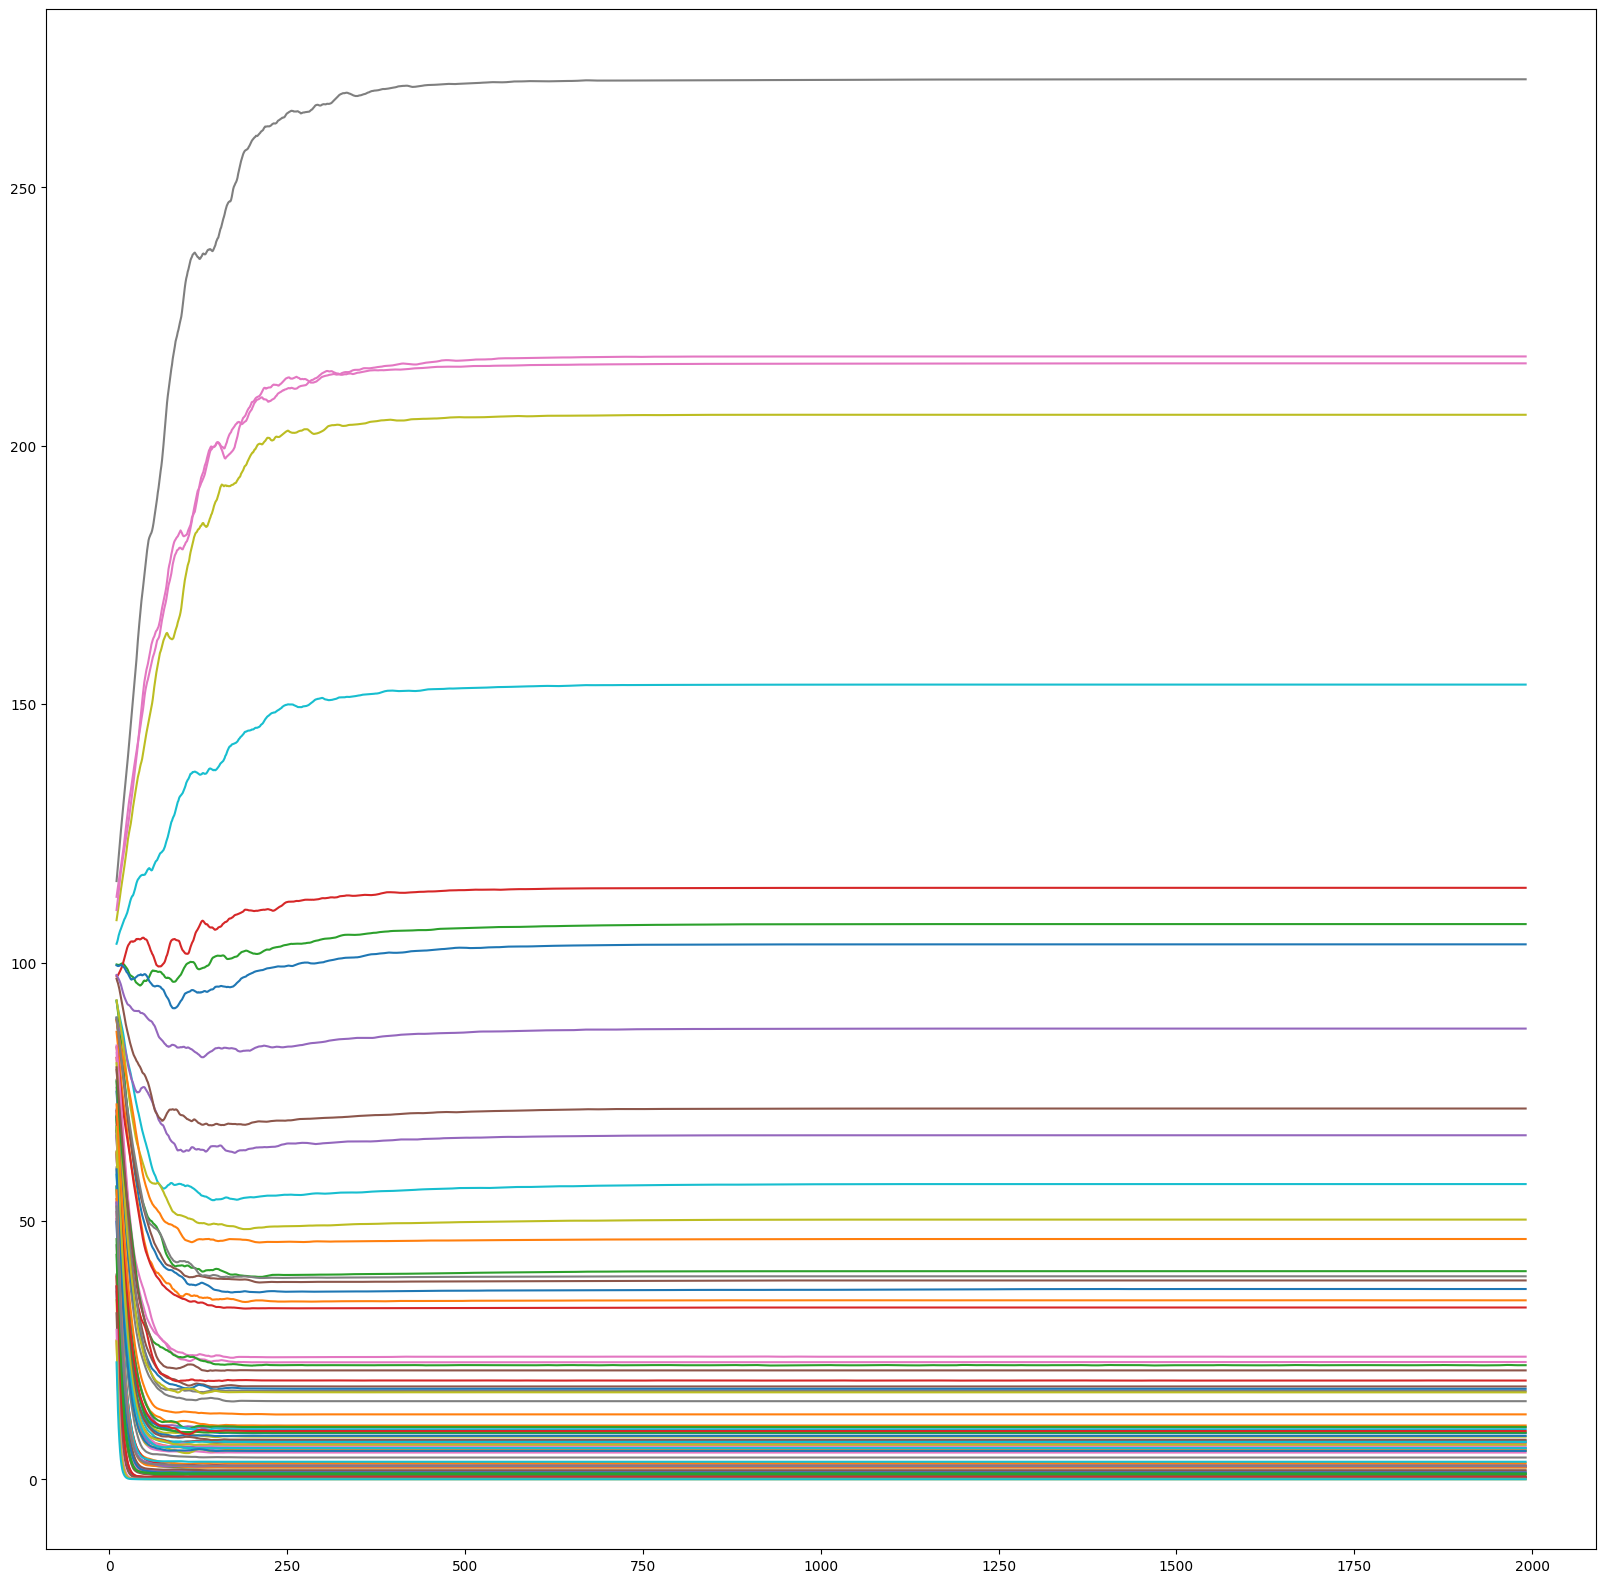

In [26]:
plt.figure(figsize=(20,20))
plt.plot(ds_reg_models_vol_roll.sel(rgi_reg='11').isel(model_author=0).isel(simulation_year=slice(0,2000)));

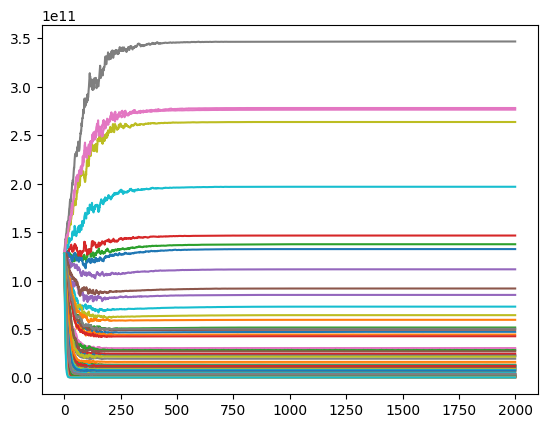

In [ ]:
plt.plot()

In [146]:
v_diff_20_yr_last_yr_above_1perc+1

experiments
1851-1870_hist_gfdl-esm4           219
1851-1870_hist_ipsl-cm6a-lr        220
1851-1870_hist_mpi-esm1-2-hr       230
1851-1870_hist_mri-esm2-0          234
1851-1870_hist_ukesm1-0-ll         248
                                  ... 
2081-2100_ssp585_gfdl-esm4        1469
2081-2100_ssp585_ipsl-cm6a-lr     1472
2081-2100_ssp585_mpi-esm1-2-hr     159
2081-2100_ssp585_mri-esm2-0        160
2081-2100_ssp585_ukesm1-0-ll       177
Name: simulation_year, Length: 80, dtype: int64

In [144]:
# those years where the difference gets again above 1 % above are now updated by the yr where the difference is the last time above 1 perc 
v_diff_20_yr_1perc_pot_eq_yr.loc[v_diff_20_yr_1perc_pot_eq_yr <v_diff_20_yr_last_yr_above_1perc] = 

experiments
1851-1870_hist_gfdl-esm4          128
1851-1870_hist_ipsl-cm6a-lr       160
1851-1870_hist_mpi-esm1-2-hr       52
1851-1870_hist_mri-esm2-0         142
1851-1870_hist_ukesm1-0-ll         98
                                 ... 
2081-2100_ssp585_gfdl-esm4         83
2081-2100_ssp585_ipsl-cm6a-lr      81
2081-2100_ssp585_mpi-esm1-2-hr     85
2081-2100_ssp585_mri-esm2-0       116
2081-2100_ssp585_ukesm1-0-ll       84
Name: simulation_year, Length: 80, dtype: int64

In [138]:
v_diff_20_yr_last_yr_above_1perc

experiments
1851-1870_hist_gfdl-esm4           218
1851-1870_hist_ipsl-cm6a-lr        219
1851-1870_hist_mpi-esm1-2-hr       229
1851-1870_hist_mri-esm2-0          233
1851-1870_hist_ukesm1-0-ll         247
                                  ... 
2081-2100_ssp585_gfdl-esm4        1468
2081-2100_ssp585_ipsl-cm6a-lr     1471
2081-2100_ssp585_mpi-esm1-2-hr     158
2081-2100_ssp585_mri-esm2-0        159
2081-2100_ssp585_ukesm1-0-ll       176
Name: simulation_year, Length: 80, dtype: int64